In [1]:
import os
print(os.getcwd())
os.chdir("..")



/home/icb/florin.ratajczak/ppi-core-genes/speos


In [2]:
from coregenes.utils.datahandlers import ResultsHandler
from coregenes.utils.metrics import MetricsHelper

import numpy as np

In [151]:
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/big_bagging3.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/big_bagging_mse_2.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/big_bagging_mse.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/big_bagging_mse_fc.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/big_bagging_lambda.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/big_bagging_approxndcg.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/big_bagging_neuralndcg2.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/linkx_mse_4.h5", read_only=True)
handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/linkx_mse_l1_1e-1.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/linkx_mse_l1_1e-2.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/linkx_mse_l1_1e-3.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/linkx_mse_l1_1e-4.h5", read_only=True)
#handler = ResultsHandler("/storage/groups/epigenereg01/projects/ppi-florin/results/linkx_mse_l1_1e-5.h5", read_only=True)


results = handler.results_dset[:,:,:]

In [40]:
#handler.close()
indices.shape

results[:,:,2] = 0

In [14]:
truth = results[0,:,0]
indices = np.where(results[:,:,4:6])[1]
predictions_val = results[:,:,2][((results[:,:,4] == 1) + (results[:,:,5] == 1))]
both = np.stack((indices, predictions_val),axis=1)
both_sorted = both[both.T[0,:].argsort()]
split_by_index =  [np.median(array) for array in np.split(both_sorted[:, 1], np.unique(both_sorted[:, 0], return_index=True)[1][1:])]
len(split_by_index)

16433

In [41]:

def eval_bagging_ensemble(results_, p=1, target="val"):
    if p < 1:
        indices = results_.shape[0]
        import random
        choices = random.choices(range(indices), k=int(indices * p))
        results_ = results_[choices, :, :]
    if target == "val":
        truth = results_[0,:,0]
        indices = np.where(results_[:,:,4:6])[1]
        predictions = results_[:,:,2][((results_[:,:,4] == 1) + (results_[:,:,5] == 1))]
    elif target == "train":
        truth = results_[0,:,0][results_[0,:,5] == 0]
        indices = np.where(results_[:,:,3])[1]
        predictions = results_[:,:,2][results_[:,:,3] == 1]
         
    both = np.stack((indices, predictions),axis=1)
    both_sorted = both[both.T[0,:].argsort()]
    split_by_index =  [np.median(array) for array in np.split(both_sorted[:, 1], np.unique(both_sorted[:, 0], return_index=True)[1][1:])]
    metrics = MetricsHelper(truth,masks={},pred_cutoff=0.7)
    metrics.update(np.asarray(split_by_index), "all")
    return metrics.get_metrics("auroc", "auprc", "f1", "mrr_filtered", "mean_rank_filtered", "hits_at_100_filtered")

auroc, auprc, f1, mrr, mean_rank, hitsat100 = eval_bagging_ensemble(results, 1, target="val")
print("AUROC: {}, AUPRC: {}, F1: {}, MRR: {}, Mean Rank: {}, Hits@100: {}, Target: {}".format(auroc, auprc, f1, mrr, mean_rank, hitsat100, "val"))

AUROC: 0.5, AUPRC: 0.0319479096939086, F1: 0.0, MRR: 0.0003740328289134661, Mean Rank: 8203.952380952382, Hits@100: 0.005714285714285714, Target: val


In [29]:
auroc, auprc, f1, mrr, mean_rank, hitsat100 = eval_bagging_ensemble(results, target="train")
print("AUROC: {}, AUPRC: {}, F1: {}, MRR: {}, Mean Rank: {}, Hits@100: {}, Target: {}".format(auroc, auprc, f1, mrr, mean_rank, hitsat100, "train"))

AUROC: 0.9677508419172622, AUPRC: 0.7821942306229849, F1: 0.724848484848485, MRR: 0.18065783592371035, Mean Rank: 488.3815261044177, Hits@100: 0.7008032128514057, Target: train


In [7]:
truth_train = results[0,:,0][results[0,:,5] == 0]
indices = np.where(results[:,:,3])[1]
predictions_val = results[:,:,2][results[:,:,3] == 1]
both = np.stack((indices, predictions_val),axis=1)
both_sorted = both[both.T[0,:].argsort()]
split_by_index_train =  [np.median(array) for array in np.split(both_sorted[:, 1], np.unique(both_sorted[:, 0], return_index=True)[1][1:])]

truth = results[0,:,0]
indices = np.where(results[:,:,4:6])[1]
predictions_val = results[:,:,2][((results[:,:,4] == 1) + (results[:,:,5] == 1))]
both = np.stack((indices, predictions_val),axis=1)
both_sorted = both[both.T[0,:].argsort()]
split_by_index =  [np.median(array) for array in np.split(both_sorted[:, 1], np.unique(both_sorted[:, 0], return_index=True)[1][1:])]

true_pos_train = np.asarray(split_by_index_train)[truth_train.astype(np.bool8)] 
true_neg_train = np.asarray(split_by_index_train)[~truth_train.astype(np.bool8)] 
true_pos_val = np.asarray(split_by_index)[truth.astype(np.bool8)]
true_neg_val = np.asarray(split_by_index)[~truth.astype(np.bool8)]

In [36]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

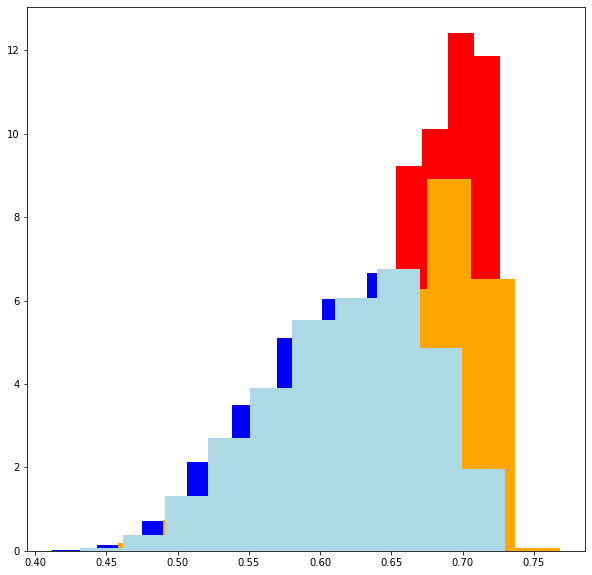

In [76]:
plt.hist(true_pos_train,color="red",density=True)
plt.hist(true_neg_train,color="blue",density=True)
plt.hist(true_pos_val,color="orange",density=True)
plt.hist(true_neg_val,color="lightblue",density=True)
plt.show()

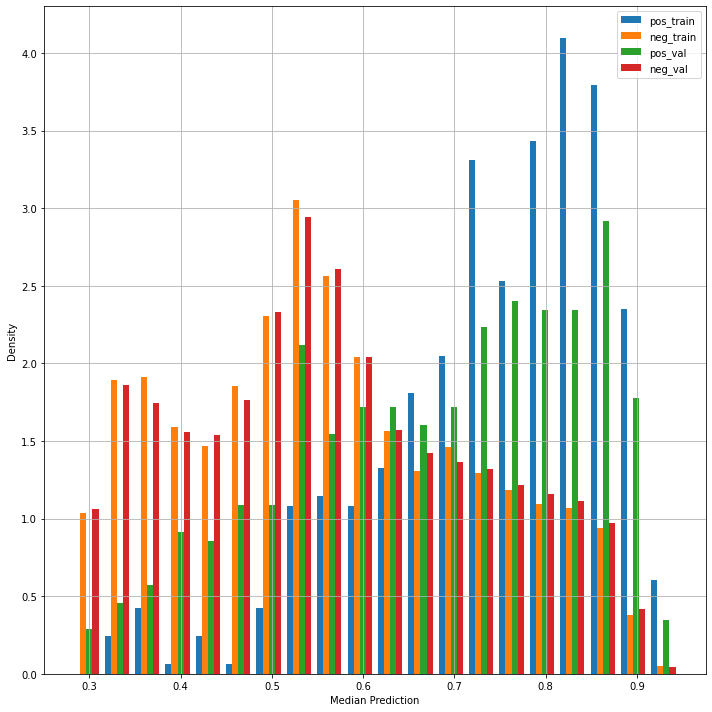

In [105]:
plt.hist([true_pos_train,true_neg_train,true_pos_val,true_neg_val],label=["pos_train","neg_train","pos_val","neg_val"],density=True,bins=20)
plt.xlabel("Median Prediction")
plt.ylabel("Density")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("predicted_scores_bce_gcn.jpg")

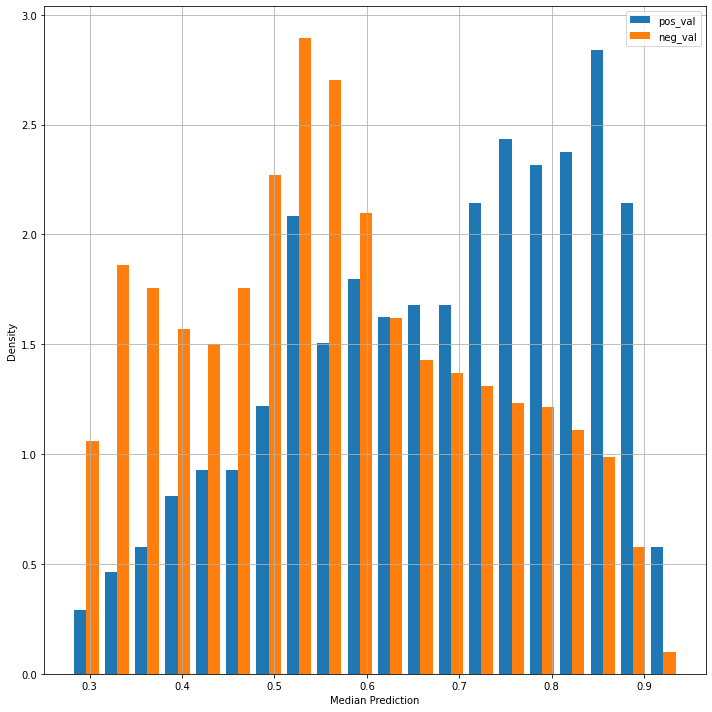

In [106]:
plt.hist([true_pos_val,true_neg_val],label=["pos_val","neg_val"],density=True,bins=20)
plt.xlabel("Median Prediction")
plt.ylabel("Density")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("predicted_scores_bce_gcn_val.jpg")

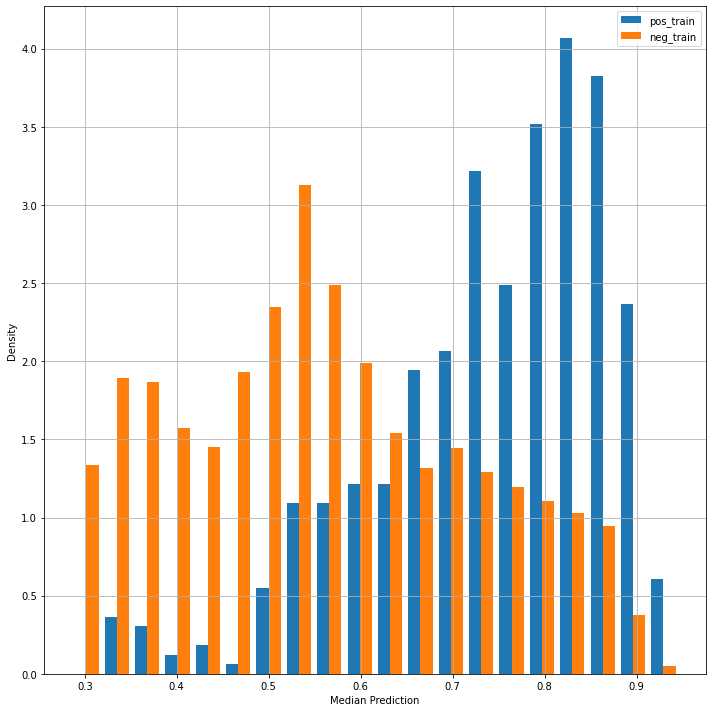

In [107]:
plt.hist([true_pos_train,true_neg_train],label=["pos_train","neg_train"],density=True,bins=20)
plt.xlabel("Median Prediction")
plt.ylabel("Density")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("predicted_scores_bce_gcn_train.jpg")

In [53]:
candidate_genes = handler.file["index"][:].astype(str).squeeze()[np.where(true_neg_train>0.7)]

In [58]:
np.savetxt("candidate_genes_bagging_mse_immune_dysregulation.txt", candidate_genes,fmt="%s")

In [43]:
def probe_bagging_results(results, num_takes = 10, target="val", parallel=False, n_jobs=10):

    aurocs_means = list()
    auprcs_means = list() 
    f1s_means = list() 
    mrrs_means = list() 
    mean_ranks_means = list()
    hitsat100s_means = list()
    num_models_list = list()

    aurocs_serrs = list()
    auprcs_serrs = list() 
    f1s_serrs = list() 
    mrrs_serrs = list() 
    mean_ranks_serrs = list()
    hitsat100s_serrs = list()

    for percentage in [p / 10 for p in list(range(1,11))]:
        num_models = int(results.shape[0] * percentage)
        aurocs = list()
        auprcs = list() 
        f1s = list() 
        mrrs = list() 
        mean_ranks = list()
        hitsat100s = list()

        if percentage != 1 and parallel:
            from joblib import Parallel, delayed
            lists = Parallel(n_jobs=1)(delayed(eval_bagging_ensemble)(results, percentage, target=target) for _ in range(num_takes))
            auroc, auprc, f1, mrr, mean_rank, hitsat100 = zip(*lists)
        else:
            for i in range(num_takes):
                try:
                    auroc, auprc, f1, mrr, mean_rank, hitsat100 = eval_bagging_ensemble(results, percentage, target=target)
                except ValueError:
                    auroc, auprc, f1, mrr, mean_rank, hitsat100 = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
                aurocs.append(auroc)
                auprcs.append(auprc)
                f1s.append(f1)
                mrrs.append(mrr)
                mean_ranks.append(mean_rank)
                hitsat100s.append(hitsat100)

                if percentage == 1:
                    # if 100% of models are used, we don't need to sample 5 times since samples are identical
                    break

        aurocs_means.append(np.mean(aurocs))
        auprcs_means.append(np.mean(auprcs))
        f1s_means.append(np.mean(f1s))
        mrrs_means.append(np.mean(mrrs))
        mean_ranks_means.append(np.mean(mean_ranks))
        hitsat100s_means.append(np.mean(hitsat100s))
        num_models_list.append(np.mean(num_models))

        aurocs_serrs.append(np.std(aurocs, ddof=1) / np.sqrt(np.size(aurocs)))
        auprcs_serrs.append(np.std(auprcs, ddof=1) / np.sqrt(np.size(auprcs)))
        f1s_serrs.append(np.std(f1s, ddof=1) / np.sqrt(np.size(f1s)))
        mrrs_serrs.append(np.std(mrrs, ddof=1) / np.sqrt(np.size(mrrs)))
        mean_ranks_serrs.append(np.std(mean_ranks, ddof=1) / np.sqrt(np.size(mean_ranks)))
        hitsat100s_serrs.append(np.std(hitsat100s, ddof=1) / np.sqrt(np.size(hitsat100s)))

    resultsdict = {"AUROC": [aurocs_means, aurocs_serrs],
                   "AUPRC": [auprcs_means, auprcs_serrs],
                   "F1 Score": [f1s_means, f1s_serrs],
                   "MRR": [mrrs_means, mrrs_serrs],
                   "Mean Rank": [mean_ranks_means, mean_ranks_serrs],
                   "Hits@100": [hitsat100s_means, hitsat100s_serrs]}

    return resultsdict, num_models_list

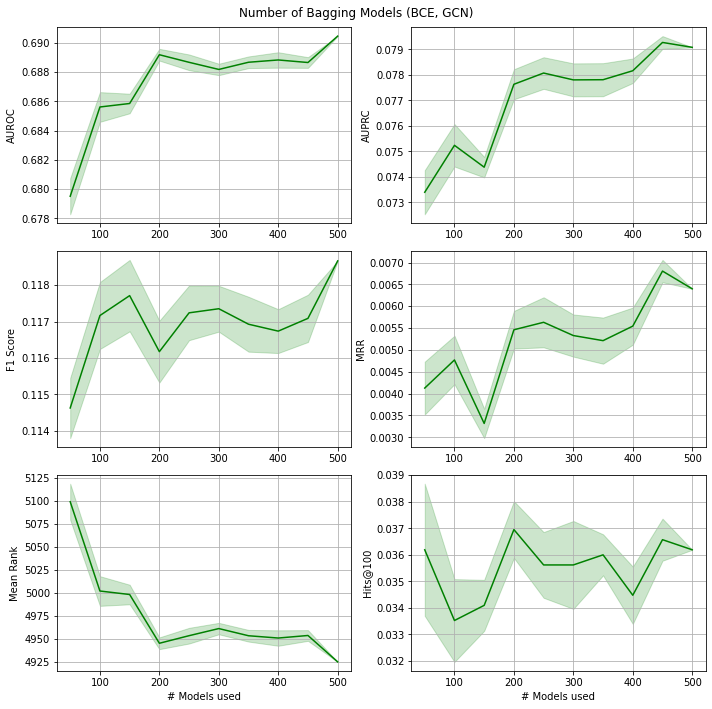

In [111]:
fig, axs = plt.subplots(3,2)

resultsdict, num_models_list = probe_bagging_results(results)

for i, (ax, (label, (values, stderrs))) in enumerate(zip(axs.reshape(-1), resultsdict.items())):
    stderrs = np.asarray(stderrs)
    stderrs[np.isnan(stderrs)] = 0
    mins = [value - stderr for value, stderr in zip(values,stderrs)]
    #mins.append(values[-1])
    maxs = [value + stderr for value, stderr in zip(values,stderrs)]
    #maxs.append(values[-1])
    ax.plot(num_models_list, values,color='green')
    ax.fill_between(num_models_list,mins,maxs,color='green', alpha=0.2)
    ax.set_ylabel(label)
    ax.grid(True)
    if i > 3:
        ax.set_xlabel('# Models used')

plt.suptitle("Number of Bagging Models (BCE, GCN)")

plt.tight_layout()
plt.savefig("bagging_bce_gcn.jpg")

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/icb/florin.ratajczak/an

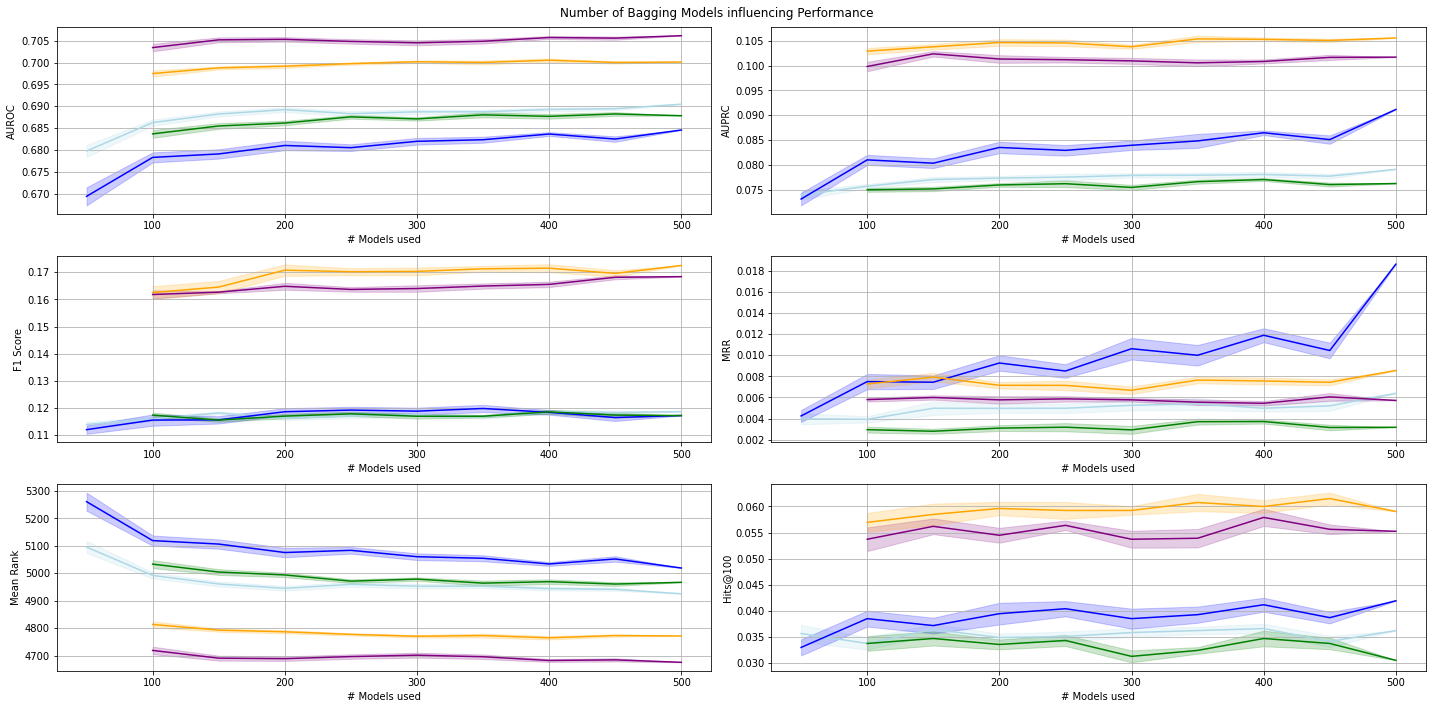

In [44]:
import os
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

base_path = "/storage/groups/epigenereg01/projects/ppi-florin/results/"

run_names = {"(GCN, BCE)": os.path.join(base_path, "big_bagging3.h5"),
             "(GCN, MSE)": os.path.join(base_path, "big_bagging_mse_2.h5"),
             "(GCN, LambdaRank)": os.path.join(base_path, "big_bagging_lambda.h5"),
             "(FC, MSE)": os.path.join(base_path, "big_bagging_mse_fc.h5"),
             "(LINKX, MSE)": os.path.join(base_path, "linkx_mse_l1_1e-2.h5")}

colors = {"(GCN, BCE)": "lightblue",
          "(GCN, MSE)": "blue",
          "(GCN, LambdaRank)": "green",
          "(FC, MSE)": "purple",
          "(LINKX, MSE)": "orange"}

def compare_runs(run_path_dict, color_dict, target="val", parallel=False, n_jobs=10):
    fig, axs = plt.subplots(3,2)

    for name, path in run_path_dict.items():
        handler = ResultsHandler(path, read_only=True)
        results = handler.results_dset[:,:,:]

        resultsdict, num_models_list = probe_bagging_results(results, target=target, parallel=parallel)

        for i, (ax, (label, (values, stderrs))) in enumerate(zip(axs.reshape(-1), resultsdict.items())):
            stderrs = np.asarray(stderrs)
            stderrs[np.isnan(stderrs)] = 0
            mins = [value - stderr for value, stderr in zip(values,stderrs)]
            maxs = [value + stderr for value, stderr in zip(values,stderrs)]
            ax.plot(num_models_list, values,color=color_dict[name])
            ax.fill_between(num_models_list,mins,maxs,color=color_dict[name], alpha=0.2)
            ax.set_ylabel(label)
            ax.grid(True)
            ax.set_xlabel('# Models used')

        plt.suptitle("Number of Bagging Models influencing Performance")

        plt.tight_layout()
        plt.savefig("bagging_all_{}.jpg".format(target))

compare_runs(run_names, colors, target="val")

In [60]:
candidate_genes_val = handler.file["index"][:].astype(str).squeeze()[np.where(true_neg_val>0.7)]

In [63]:
set(candidate_genes_val).intersection(set(candidate_genes)) 

{'A2M',
 'ANKRD63',
 'CCDC186',
 'DISP3',
 'FADD',
 'GLRX5',
 'IMPA1',
 'LEFTY2',
 'LMBR1L',
 'LTA4H',
 'MAJIN',
 'NUDT16L1',
 'OST4',
 'PRR4',
 'VRK2',
 'YAF2',
 'ZNF223'}

In [76]:
np.sum(handler.get_results_for_gene("ABCA1").squeeze()[:,3])

381.0

In [242]:
def recall_at_k(r, k):
    """Score is recall @ k
    Relevance is binary (nonzero is relevant).
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        recall @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    top_r = np.asarray(r)[:k] != 0
    if top_r.size != k:
        raise ValueError('Relevance score length < k')
    return np.sum(top_r)/np.sum(r)

recall_at_k(ordered_truth_val,500)

0.11222444889779559

In [247]:
r = [0, 0, 1]
print(recall_at_k(r,1), precision_at_k(r,1))
print(recall_at_k(r,3), precision_at_k(r,3))

0.0 0.0
1.0 0.3333333333333333


In [218]:
ordered_truth_val

array([1., 0., 0., ..., 0., 0., 0.])

In [192]:
np.mean([1. / (r + 1) for sublist in rs for r in sublist]) 

0.9999679713022869

In [196]:
np.mean(np.where(random_rs))

3922.8446893787577

In [269]:
precision_at_k(ordered_truth_val,500)

0.122

In [270]:
ndcg_at_k(ordered_truth_val,5)

0.4211582832992166

In [222]:
def get_metrics(rs, additional_truth=None, get_hits=[]):
        """Score is reciprocal of the rank of the first relevant item
        First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
        Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
        >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
        >>> mean_reciprocal_rank(rs)
        0.61111111111111105
        >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
        >>> mean_reciprocal_rank(rs)
        0.5
        >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
        >>> mean_reciprocal_rank(rs)
        0.75
        Args:
            rs: Iterator of relevance scores (list or numpy) in rank order
                (first element is the first item)
        Returns:
            Mean reciprocal rank
        """
        rs_raw = list(np.asarray(r).nonzero()[0] for r in rs if np.sum(r) > 0)
        
        mrr_raw = np.mean([1. / (r + 1) for sublist in rs_raw for r in sublist]) 
        mean_rank_raw = np.mean([r + 1 for sublist in rs_raw for r in sublist]) 

        hitsat5_raw = np.mean([1 if r < 5 else 0 for sublist in rs_raw for r in sublist]) 
        hitsat10_raw = np.mean([1 if r < 10 else 0 for sublist in rs_raw for r in sublist]) 
        hitsat20_raw = np.mean([1 if r < 20 else 0 for sublist in rs_raw for r in sublist]) 
        hitsat50_raw = np.mean([1 if r < 50 else 0 for sublist in rs_raw for r in sublist]) 

        total_before = np.sum(rs)

        rs_filtered = []
        if additional_truth is not None:
        #if True:
            # also remove all known true examples from the other sets
            rs_prefiltered = []
            for i, additional in enumerate(additional_truth):
                to_delete = additional.nonzero()[0]
                rs_prefiltered.append(np.delete(rs[i],to_delete)) 
            
            total_after = np.sum(np.sum(r) for r in rs_prefiltered)
            assert  total_before == total_after # nothing lost filtering for out-of-sample edges
            rs = rs_prefiltered

        for r in rs:
            while np.sum(r) > 0:
                best = r.nonzero()[0][0]
                best_r = np.zeros_like(r)
                best_r[best] = 1
                rs_filtered.append(best_r)
                r = np.delete(r, best)

        total_after = np.sum(np.sum(r) for r in rs_filtered)
        assert total_before == total_after # nothing lost in filtering
        assert len(rs_filtered) == total_before # every edge gets its own array
        for r in rs_filtered:
            assert np.sum(r) == 1 # only one edge in every array

        
        rs_filtered = list(np.asarray(r).nonzero()[0] for r in rs_filtered if np.sum(r) > 0)
        mrr_filtered = np.mean([1. / (r + 1) if r.size else 0. for r in rs_filtered]) 
        mean_rank_filtered = np.mean([r + 1 if r.size else 0. for r in rs_filtered]) 

        hitsat5_filtered = np.mean([1 if r < 5 else 0 for sublist in rs_filtered for r in sublist])
        hitsat10_filtered = np.mean([1 if r < 10 else 0 for sublist in rs_filtered for r in sublist])
        hitsat20_filtered = np.mean([1 if r < 20 else 0 for sublist in rs_filtered for r in sublist]) 
        hitsat500_filtered = np.mean([1 if r < 500 else 0 for sublist in rs_filtered for r in sublist])

        return (mrr_raw, mrr_filtered, mean_rank_raw, mean_rank_filtered, hitsat5_raw, hitsat5_filtered, hitsat10_raw, hitsat10_filtered,
            hitsat20_raw, hitsat20_filtered, hitsat50_raw, hitsat500_filtered)

In [272]:
get_metrics([ordered_truth_val])

/tmp/ipykernel_30611/1716292592.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_after = np.sum(np.sum(r) for r in rs_filtered)


(0.0043237625402892145,
 0.0043237625402892145,
 4904.75751503006,
 4904.75751503006,
 0.004008016032064128,
 0.004008016032064128,
 0.006012024048096192,
 0.006012024048096192,
 0.012024048096192385,
 0.012024048096192385,
 0.02404809619238477,
 0.12224448897795591)

In [6]:
from coregenes.utils.config import Config
from coregenes.preprocessing.preprocessor import PreProcessor
from coregenes.preprocessing.mappers import GWASMapper, AdjacencyMapper

In [70]:
config = Config()
gwasmapper = GWASMapper(config.input.gene_sets, config.input.gwas) 
adjacencymapper = AdjacencyMapper(mapping_file=config.input.adjacency_mappings)
gwasmappings = gwasmapper.get_mappings(tags="immune_dysregulation")
adjacencies = adjacencymapper.get_mappings(tags="BioPlex 3.0 293T")
preprocessor = PreProcessor(config, mapping_list=gwasmappings, adjacency_list=adjacencies, translation_table="./data/translation_table.tsv")
X,y,adj = preprocessor.get_data()

f66cc9 2022-03-28 10:37:19,253 [INFO] coregenes.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30293T']
f66cc9 2022-03-28 10:37:19,253 [INFO] coregenes.preprocessing.preprocessor: Using 7 mappings with ground truth ./data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
f66cc9 2022-03-28 10:37:49,404 [INFO] coregenes.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 19573
Number of edges: 170206
Average in degree:   8.6960
Average out degree:   8.6960


In [87]:
preprocessor.add_y_label()
ppm, idx_to_real_idx = preprocessor.positive_paths_matrix(symmetrize=False)

In [74]:
ppm

array([[0, 0, 0, ..., 4, 5, 5],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 3, 3],
       [5, 0, 0, ..., 3, 0, 2],
       [5, 0, 0, ..., 3, 2, 0]], dtype=uint8)

In [99]:
ppm_gcn = ppm.copy()
ppm_gcn[ppm_gcn > 2] = 0

In [100]:
total_connections = np.sum(ppm_gcn, axis=0)

In [101]:
priorization = np.argsort(total_connections)

In [102]:
real_idx = [idx_to_real_idx[index] for index in priorization]

In [103]:
total_connections[priorization]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [93]:
ppm.max()

8

In [152]:
truth = results[0,:,0]
indices = np.where(results[:,:,4:6])[1]
predictions = results[:,:,2][((results[:,:,4] == 1) + (results[:,:,5] == 1))]
both = np.stack((indices, predictions),axis=1)
both_sorted = both[both.T[0,:].argsort()]
split_by_index =  [np.median(array) for array in np.split(both_sorted[:, 1], np.unique(both_sorted[:, 0], return_index=True)[1][1:])]

In [53]:
both_sorted

array([[0.00000000e+00, 4.55586433e-01],
       [0.00000000e+00, 5.74376523e-01],
       [0.00000000e+00, 6.43465459e-01],
       ...,
       [1.64320000e+04, 7.90297508e-01],
       [1.64320000e+04, 7.94648826e-01],
       [1.64320000e+04, 8.71789038e-01]])

In [153]:
prioritized_predictions = np.asarray(split_by_index)[real_idx]

In [116]:
locations = [0]
prev_neighbor = 0
distance = 0
for neighbor in total_connections[priorization]:
    if neighbor == prev_neighbor:
        distance += 1
    else:
        locations.append(distance)
    prev_neighbor = neighbor

labels = np.unique(total_connections[priorization])


In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
symbols = handler.file.get("index")[:].astype(str).squeeze()

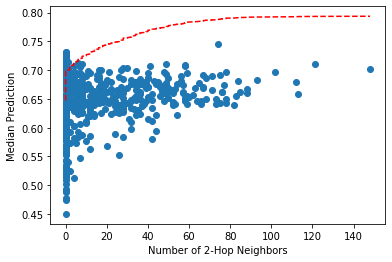

In [127]:
plt.scatter(total_connections[priorization], prioritized_predictions)

z = np.polyfit(total_connections[priorization], prioritized_predictions, 1)
p = np.poly1d(z)
plt.plot(total_connections[priorization], p(range(len(prioritized_predictions))), "r--")
plt.ylabel("Median Prediction")
plt.xlabel("Number of 2-Hop Neighbors")
#plt.xticks(locations)
plt.show()

In [156]:
import plotly.express as px

fig = px.scatter(x=total_connections[priorization], y=prioritized_predictions, custom_data=[symbols[real_idx]], trendline="ols",
                labels=dict(x="Number of positive 2-Hop Neighbors", y="Median Prediction"), title="Number of positive Neighbors influences Prediction in LINKX")

fig.update_traces(
    hovertemplate="<br>".join([
        "# 2-Hop Neighbors: %{x}",
        "Median Prediction: %{y}",
        "HGNC: %{customdata[0]}",
    ])
)


fig.show()

[[8.75979974e-03 5.19498095e+03 6.81815296e-01 1.04185872e-01]
 [6.72574349e-03 5.20256429e+03 6.81742424e-01 1.00636322e-01]
 [6.81506247e-03 5.74036905e+03 6.52139250e-01 9.39982603e-02]
 [7.60938318e-03 5.26943571e+03 6.76664502e-01 1.00235484e-01]
 [6.36514121e-03 5.54963571e+03 6.60943723e-01 8.96918701e-02]
 [4.87419735e-03 5.34073095e+03 6.74357864e-01 9.23345947e-02]]
[[9.00098232e-03 5.87383571e+03 6.43994949e-01 8.46290838e-02]
 [1.39578312e-02 5.53719762e+03 6.61637085e-01 1.01430904e-01]
 [9.10137484e-03 6.06945952e+03 6.32730159e-01 7.46369084e-02]
 [9.37928069e-03 5.91207381e+03 6.41046176e-01 7.92473272e-02]
 [9.25107275e-03 5.95203333e+03 6.37877345e-01 8.35453265e-02]
 [1.23841365e-02 5.77675238e+03 6.46698413e-01 9.48513525e-02]]
[[9.11957202e-03 5.46277143e+03 6.70399711e-01 9.37989070e-02]
 [8.16502485e-03 5.14056190e+03 6.86880952e-01 9.83113241e-02]
 [5.00299387e-03 5.96663571e+03 6.40334776e-01 7.65958140e-02]
 [6.54767124e-03 5.63374048e+03 6.57165945e-01 9.3553

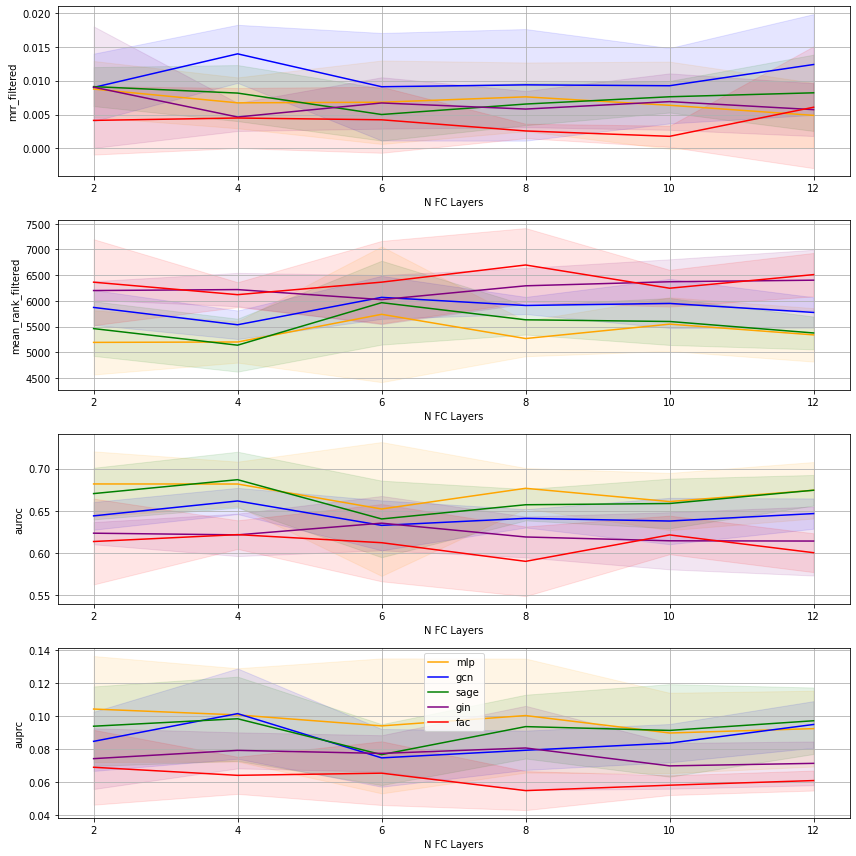

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["mlp","gcn","sage","gin","fac"]
#df_paths = ["../{}_benchmark.tsv".format(method) for method in methods]
df_paths = ["../grndb_adipose_{}_benchmark.tsv".format(method) for method in methods]
num_folds = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))

colors = ["orange",
          "blue",
          "green",
          "purple",
          "red"]
patches = {}

for k, df_path in enumerate(df_paths):
    df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
    means = np.empty((len(df.index) // num_folds, len(df.columns)))
    sds = np.empty((len(df.index) // num_folds, len(df.columns)))
    maxes = np.empty((len(df.index) // num_folds, len(df.columns)))
    mins = np.empty((len(df.index) // num_folds, len(df.columns)))

    for i, start in enumerate(range(0, len(df.index), num_folds)):
        one_run = df[start:(start + num_folds)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    print(means)
    for j, ax in enumerate(axes):
        patch, = ax.plot(means[:,j], color=colors[k])
        patches.update({k: patch})

        ax.fill_between([0,1,2,3,4,5], means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks([0,1,2,3,4,5], ["2","4","6","8","10","12"])
        ax.set_xlabel('N FC Layers')


plt.legend(list(patches.values()), methods)
plt.tight_layout()
plt.show()

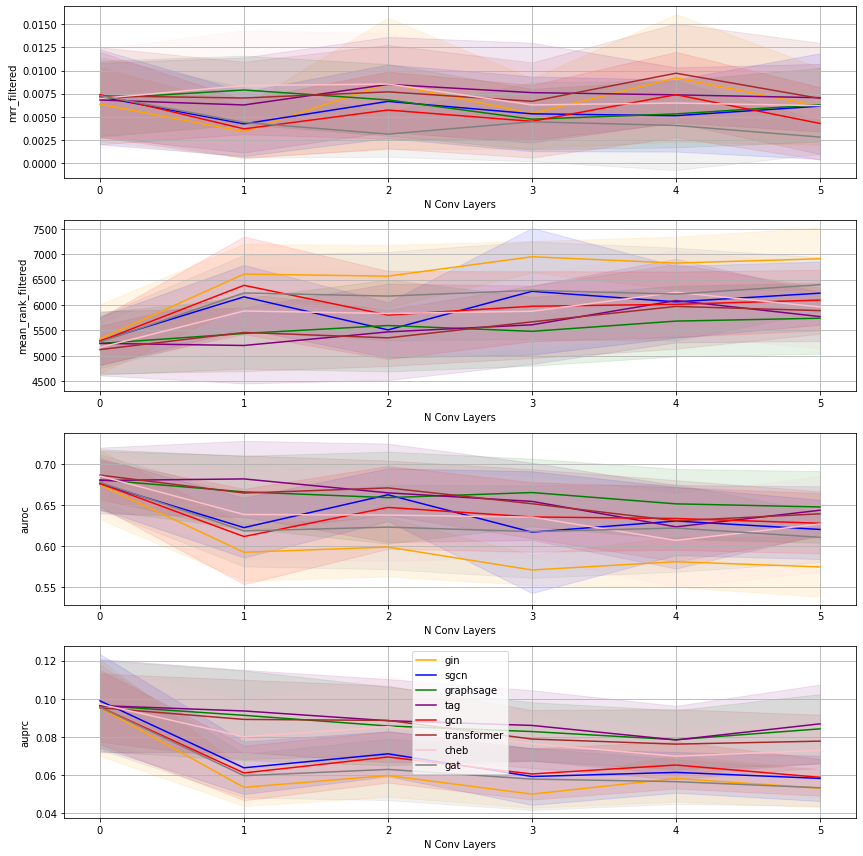

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["gin","sgcn", "graphsage","tag","gcn","transformer","cheb", "gat"]
#df_paths = ["../{}_benchmark.tsv".format(method) for method in methods]
df_paths = ["../bioplex_{}_benchmark_depth.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))

colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        patch, = ax.plot(means[:,j], color=colors[k])
        patches.update({k: patch})

        ax.fill_between([0,1,2,3,4,5], means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between([0,1,2,3,4,5], mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks([0,1,2,3,4,5], ["0","1","2","3","4","5"])
        ax.set_xlabel('N Conv Layers')


plt.legend(list(patches.values()), methods)
plt.tight_layout()
plt.show()

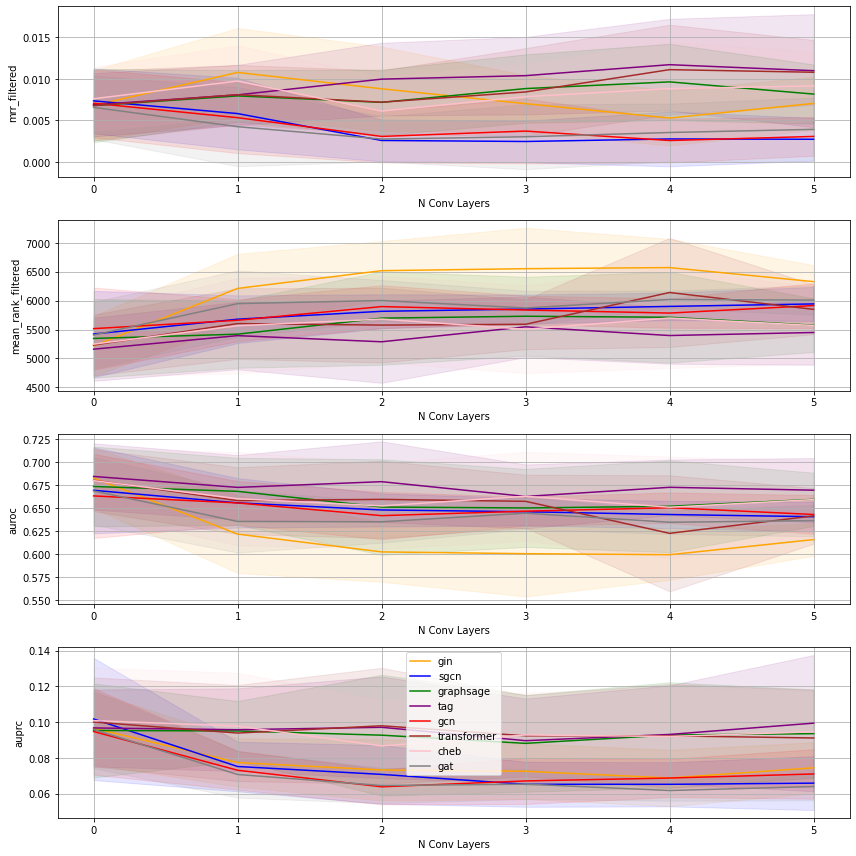

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["gin","sgcn", "graphsage","tag","gcn","transformer","cheb", "gat"]
#df_paths = ["../{}_benchmark.tsv".format(method) for method in methods]
df_paths = ["../grndb_adipose_{}_benchmark_depth.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
used_methods = []
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))

colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        patch, = ax.plot(means[:,j], color=colors[k])
        patches.update({k: patch})

        ax.fill_between([0,1,2,3,4,5], means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between([0,1,2,3,4,5], mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks([0,1,2,3,4,5], ["0","1","2","3","4","5"])
        ax.set_xlabel('N Conv Layers')


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

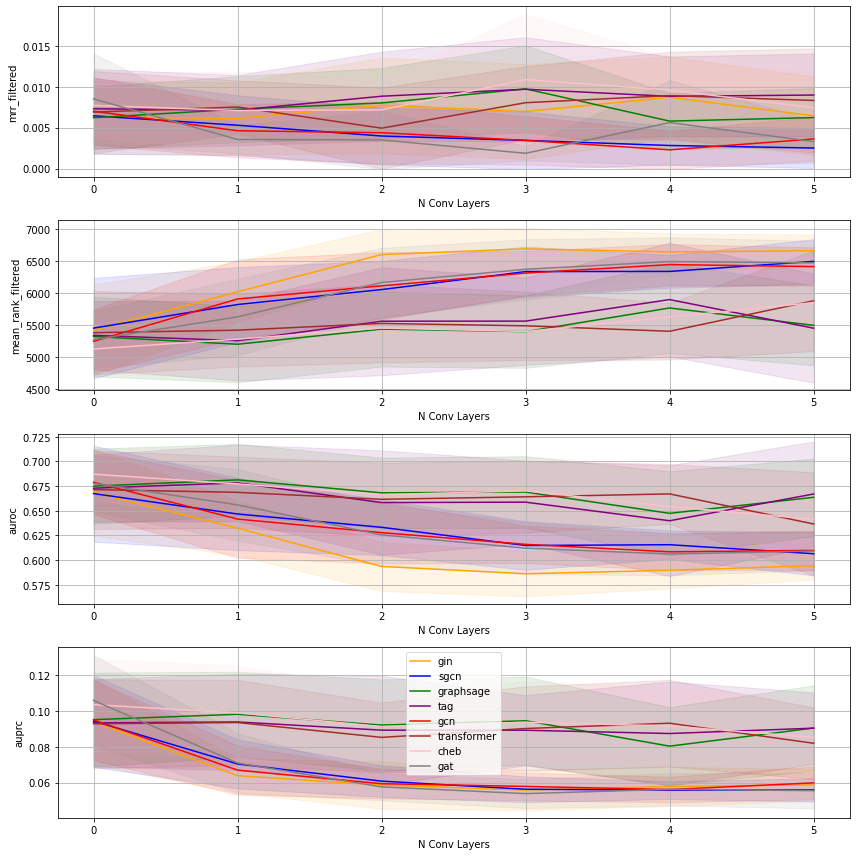

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["gin","sgcn", "graphsage","tag","gcn","transformer","cheb", "gat"]
#df_paths = ["../{}_benchmark.tsv".format(method) for method in methods]
df_paths = ["../grndb_pituitary_{}_benchmark_depth.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        patch, = ax.plot(means[:,j], color=colors[k])
        patches.update({k: patch})

        ax.fill_between([0,1,2,3,4,5], means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between([0,1,2,3,4,5], mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks([0,1,2,3,4,5], ["0","1","2","3","4","5"])
        ax.set_xlabel('N Conv Layers')


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

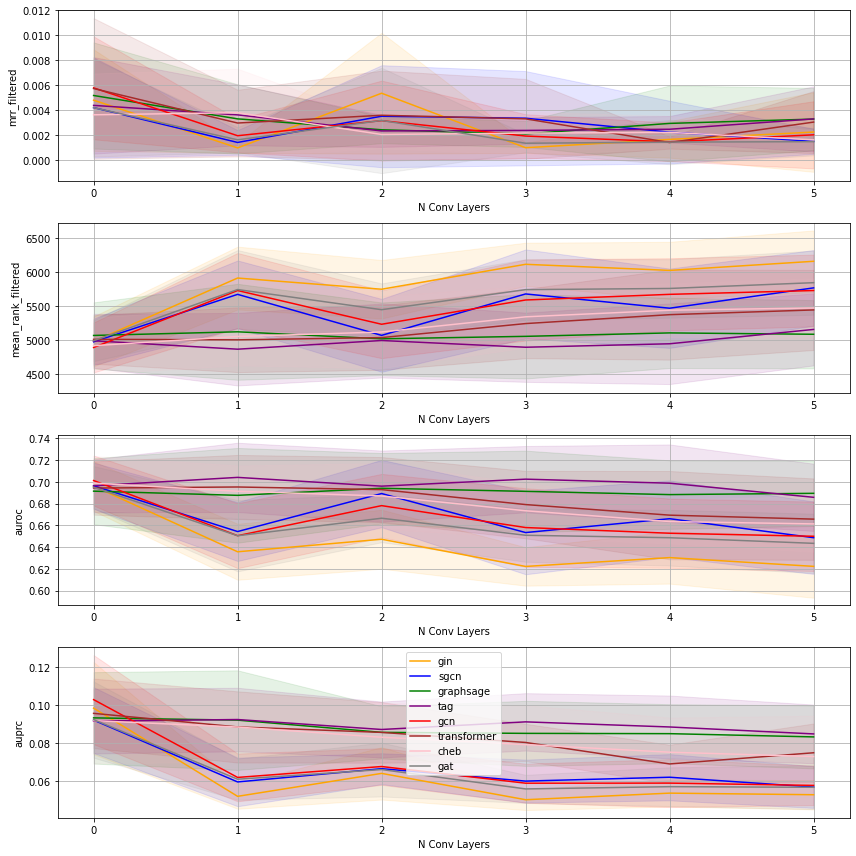

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["gin","sgcn", "graphsage","tag","gcn","transformer","cheb", "gat"]
df_paths = ["../bioplex_mr_{}_benchmark_depth.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        patch, = ax.plot(means[:,j], color=colors[k])
        patches.update({k: patch})

        ax.fill_between([0,1,2,3,4,5], means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between([0,1,2,3,4,5], mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks([0,1,2,3,4,5], ["0","1","2","3","4","5"])
        ax.set_xlabel('N Conv Layers')


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

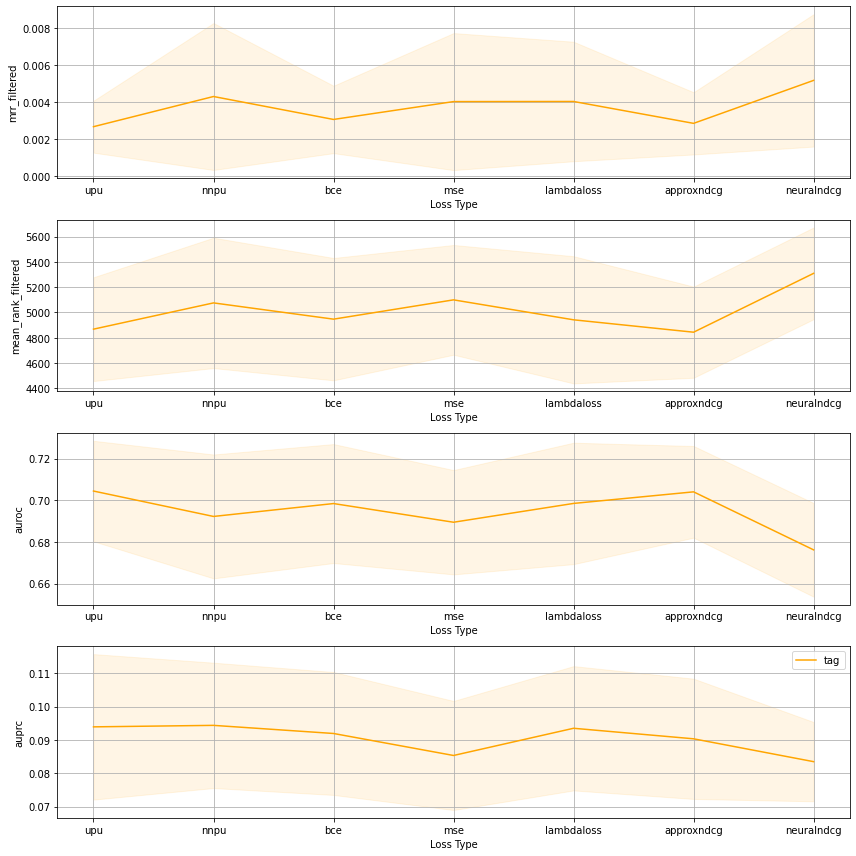

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["tag"]
df_paths = ["../bioplex_losses_{}_benchmark_loss.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        patch, = ax.plot(means[:,j], color=colors[k])
        patches.update({k: patch})

        ax.fill_between([0,1,2,3,4,5,6], means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between([0,1,2,3,4,5,6], mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks([0,1,2,3,4,5,6], ["upu","nnpu","bce","mse","lambdaloss","approxndcg", "neuralndcg"])
        ax.set_xlabel('Loss Type')


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

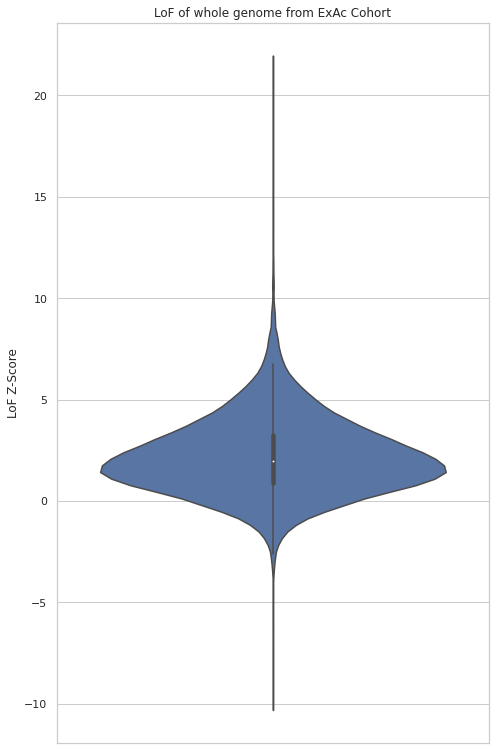

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

pli = pd.read_csv("/home/icb/florin.ratajczak/ppi-core-genes/data/forweb_cleaned_exac_r03_march16_z_data_pLI.txt", sep="\t", header=0)

sns.set_theme(style="whitegrid")
ax = sns.violinplot(y = pli["lof_z"])

ax.set_ylabel(ylabel="LoF Z-Score")
ax.set_title("LoF of whole genome from ExAc Cohort")
set_size(6,10)

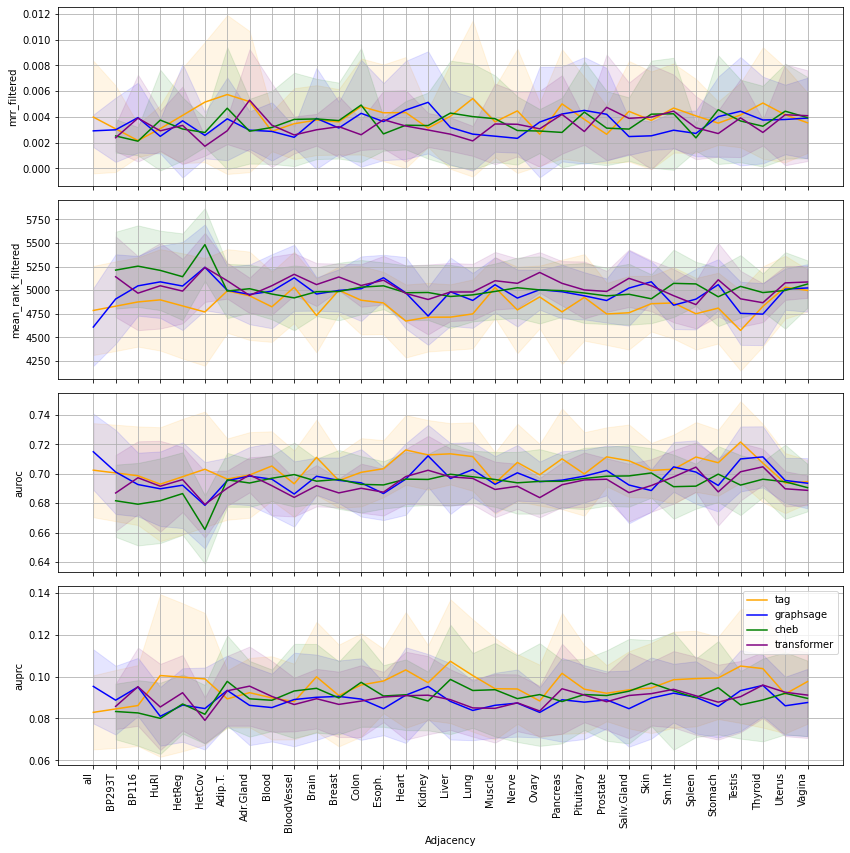

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["tag","graphsage","cheb","transformer"]
adjs = ["all","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["adjacencies_immu_{}_benchmark_adjacencies.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')
        

fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

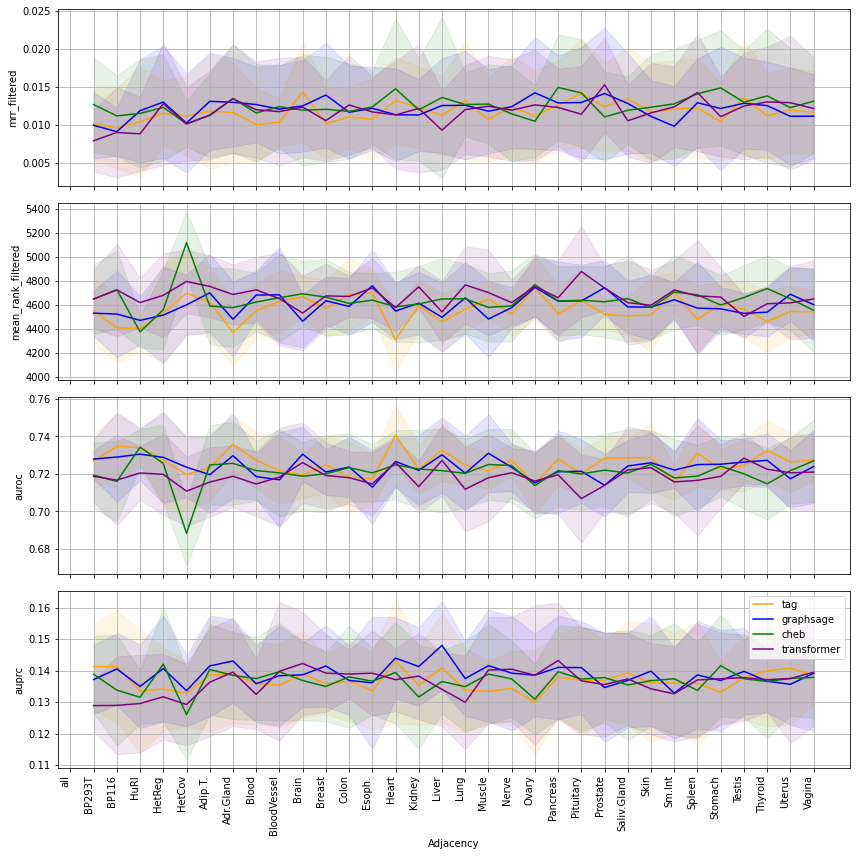

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["tag","graphsage","cheb","transformer"]
adjs = ["all","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_cardio_{}_benchmark_adjacencies.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')
        

fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

['../adjacencies_immu_tag_benchmark_adjacencies.tsv', '../adjacencies_immu_tag_concat_benchmark_adj_tag.tsv', '../adjacencies_immu_tag_skip_benchmark_adj_tag.tsv']
528
     mrr_filtered  mean_rank_filtered     auroc     auprc
0        0.001514         5276.419048  0.675608  0.069951
1        0.001812         4054.895238  0.751195  0.104501
2        0.001295         5035.314286  0.675766  0.062692
3        0.011319         4772.152381  0.707359  0.094453
4        0.001514         5276.419048  0.675608  0.069951
..            ...                 ...       ...       ...
539      0.002970         5067.733333  0.692392  0.086896
540      0.003612         5180.771429  0.681922  0.091377
541      0.001774         4657.028571  0.718216  0.104685
542      0.003007         5313.161905  0.677345  0.086805
543      0.002444         5145.552381  0.682944  0.088020

[544 rows x 4 columns]
560
                                                    mrr_filtered  \
adjacencies_immu_tag_concat_benchmark_ad

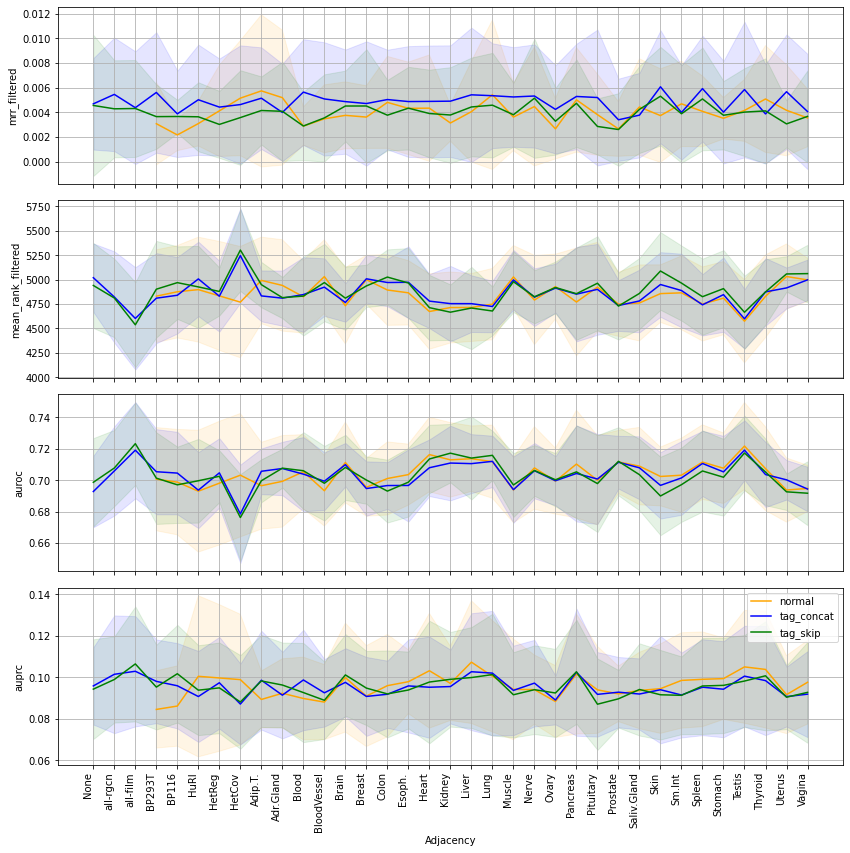

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["normal","tag_concat","tag_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_immu_{}_benchmark_adj_tag.tsv".format(method) for method in methods]
df_paths[0] = "../adjacencies_immu_tag_benchmark_adjacencies.tsv"
print(df_paths)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        print(len(df))
        if methods[k] == "normal":
            df = pd.concat([df.iloc[:16], pd.DataFrame(data=np.empty((16, 4,)) * np.nan, columns=df.columns), df.iloc[16:]], axis = 0).reset_index(drop=True)
        print(df)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

528
     mrr_filtered  mean_rank_filtered     auroc     auprc
0        0.001777         4837.723810  0.707711  0.088176
1        0.004872         3916.590476  0.757371  0.110719
2        0.002008         4829.247619  0.692364  0.070510
3        0.002998         4850.971429  0.702566  0.111824
4        0.001777         4837.723810  0.707711  0.088176
..            ...                 ...       ...       ...
539      0.007421         4909.000000  0.700398  0.105785
540      0.003553         5056.990476  0.690964  0.078151
541      0.002353         4807.771429  0.709758  0.107742
542      0.001425         5433.476190  0.664009  0.069176
543      0.012731         4565.457143  0.719296  0.117732

[544 rows x 4 columns]
560
                                                    mrr_filtered  \
adjacencies_immu_sage_concat_benchmark_adj_sage...      0.003033   
adjacencies_immu_sage_concat_benchmark_adj_sage...      0.004961   
adjacencies_immu_sage_concat_benchmark_adj_sage...      0.001195   


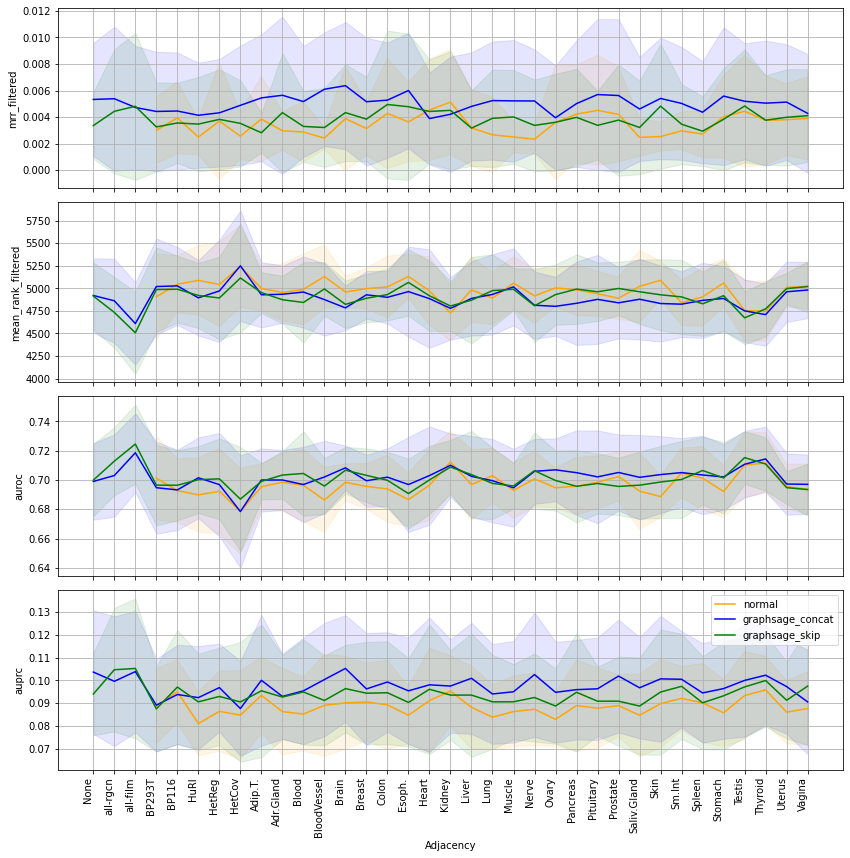

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["normal","graphsage_concat","graphsage_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_immu_{}_benchmark_adj_sage.tsv".format(method) for method in methods]
df_paths[0] = "../adjacencies_immu_graphsage_benchmark_adjacencies.tsv"
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        if methods[k] == "normal":
            df = pd.concat([df.iloc[:16], pd.DataFrame(data=np.empty((16, 4,)) * np.nan, columns=df.columns), df.iloc[16:]], axis = 0).reset_index(drop=True)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

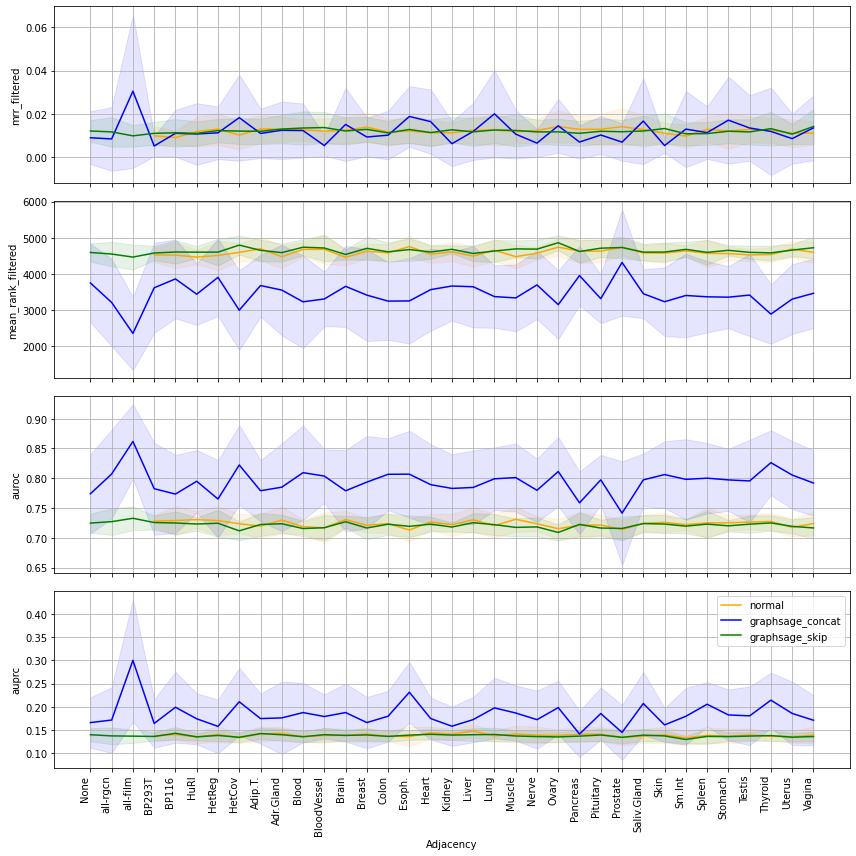

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["normal","graphsage_concat","graphsage_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_cardio_{}_benchmark_adj_sage.tsv".format(method) for method in methods]
df_paths[0] = "../adjacencies_cardio_graphsage_benchmark_adjacencies.tsv"
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        if methods[k] == "normal":
            df = pd.concat([pd.DataFrame(data=np.empty((48, 4,)) * np.nan, columns=df.columns), df], axis = 0).reset_index(drop=True)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

In [7]:

from coregenes.benchmark import TestBench

tb = TestBench("testbench_adjacencies_parameters.yaml", "testbench_config_adj_mr.yaml")
tb.compile_configs()
tb.compile_resultshandlers()


['/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30293Trep0.h5', '/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30293Trep1.h5', '/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30293Trep2.h5', '/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30293Trep3.h5', '/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30HCT116rep0.h5', '/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30HCT116rep1.h5', '/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30HCT116rep2.h5', '/lustre/groups/epigenereg01/projects/ppi-florin/results/adjacencies_tag_benchmark_adjacencies_BioPlex30HCT116rep3.h5', '/lustre/groups/epigenereg01/projects/ppi-flori

In [11]:
from coregenes.experiment import Experiment
from coregenes.benchmark import TestBench
from coregenes.datasets import DatasetBootstrapper
from coregenes.preprocessing.mappers import GWASMapper, AdjacencyMapper
import numpy as np

connected_pos_only_masks = []
disconnected_pos_only_masks = []

tb = TestBench("testbench_adjacencies_parameters_sage.yaml", "testbench_config_adj_mr_cardio_sage_concat.yaml")
tb.compile_configs()

tb.compile_resultshandlers()
tb.configs = tb.configs
tb.resultshandlers = tb.resultshandlers
tb.parameter_list = tb.parameter_list

for i, (config, resultshandler_path) in enumerate(zip(tb.configs, tb.resultshandlers)):
    if i % 4 != 0:
        continue
    mappings = GWASMapper(config.input.gene_sets, config.input.gwas).get_mappings(
            config.input.tag, fields=config.input.field)

    tag = "" if config.input.adjacency == "all" else config.input.adjacency
    adjacencies = AdjacencyMapper(config.input.adjacency_mappings).get_mappings(tag)

    dataset = DatasetBootstrapper(
            mappings, adjacencies, holdout_size=config.input.holdout_size, name=config.name, config=config).get_dataset()
    connected, disconnected = dataset.preprocessor.get_connected_components()
    disconnected_positives = np.array(disconnected[1])
    connected_positives = np.array(connected[0][1])

    connected_pos_only_mask = np.ones_like(dataset.data.y.cpu().detach().numpy())
    if len(disconnected_positives) > 0:
        connected_pos_only_mask[disconnected_positives] = 0
    connected_pos_only_masks.append(connected_pos_only_mask.astype(np.bool8))

    disconnected_pos_only_mask = np.ones_like(dataset.data.y.cpu().detach().numpy())
    if len(connected_positives) > 0:
        disconnected_pos_only_mask[connected_positives] = 0
    disconnected_pos_only_masks.append(disconnected_pos_only_mask.astype(np.bool8))

tb.metrics = ["mrr_filtered", "mean_rank_filtered"]
df_connected = tb.compare(save=False, additional_masks=np.array(connected_pos_only_masks).repeat(4,axis=0).tolist())
df_disconnected = tb.compare(save=False, additional_masks=np.array(disconnected_pos_only_masks).repeat(4, axis=0).tolist())
df_all = tb.compare(save=False)



NameError: name 'GWASMapper' is not defined

ValueError: x and y must have same first dimension, but have shapes (32,) and (35,)

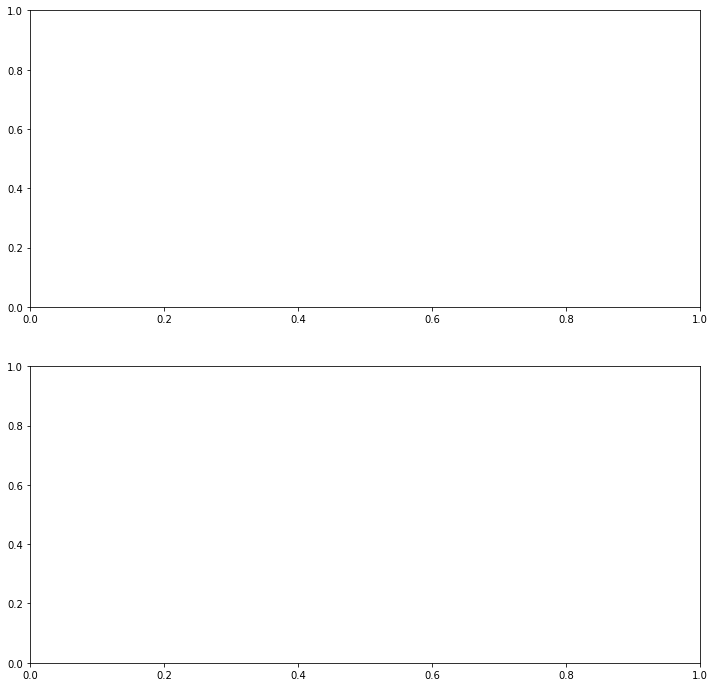

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["all","disconnected","connected"]
adjs = ["all","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

num_folds = 4
repetitions = 4
num_metrics = 2
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]

patches = {}

for k, df in enumerate([df_all, df_disconnected, df_connected]):
    step = num_folds * repetitions
    try:
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')
        if "mrr" in df.columns[j]:
            ax.set_ylim(bottom=0)
        

fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

In [12]:
import os
print(os.getcwd())
os.chdir("..")
import coregenes

/mnt/home/icb/florin.ratajczak/ppi-core-genes/coregenes


In [13]:
from coregenes.experiment import Experiment
from coregenes.benchmark import TestBench
from coregenes.utils.datahandlers import ResultsHandler
from coregenes.datasets import DatasetBootstrapper
from coregenes.preprocessing.mappers import GWASMapper, AdjacencyMapper
import numpy as np

connected_pos_only_masks = []
disconnected_pos_only_masks = []

tb = TestBench("testbench_adjacencies_parameters_tag.yaml", "testbench_config_adj_mr_immu_tag_skip.yaml")
tb.config.inference.save_dir = "/localscratch/florin.ratajczak/results/"
tb.compile_configs()

tb.compile_resultshandlers()
tb.configs = tb.configs
tb.resultshandlers = tb.resultshandlers
tb.parameter_list = tb.parameter_list

for i, (config, resultshandler_path) in enumerate(zip(tb.configs, tb.resultshandlers)):
    if i % 4 != 0:
        continue
    #resultshandler = ResultsHandler(resultshandler_path, read_only=True)
    #experiment = Experiment(config, resultshandler)
    mappings = GWASMapper(config.input.gene_sets, config.input.gwas).get_mappings(
            config.input.tag, fields=config.input.field)

    tag = "" if config.input.adjacency == "all" else config.input.adjacency
    adjacencies = AdjacencyMapper(config.input.adjacency_mappings).get_mappings(tag)

    dataset = DatasetBootstrapper(
            mappings, adjacencies, holdout_size=config.input.holdout_size, name=config.name, config=config).get_dataset()
    connected, disconnected = dataset.preprocessor.get_connected_components()
    disconnected_positives = np.array(disconnected[1])
    connected_positives = np.array(connected[0][1])

    connected_pos_only_mask = np.ones_like(dataset.data.y.cpu().detach().numpy())
    if len(disconnected_positives) > 0:
        connected_pos_only_mask[disconnected_positives] = 0
    connected_pos_only_masks.append(connected_pos_only_mask.astype(np.bool8))

    disconnected_pos_only_mask = np.ones_like(dataset.data.y.cpu().detach().numpy())
    if len(connected_positives) > 0:
        disconnected_pos_only_mask[connected_positives] = 0
    disconnected_pos_only_masks.append(disconnected_pos_only_mask.astype(np.bool8))

tb.metrics = ["mrr_filtered", "mean_rank_filtered"]

common_save_path = tb.config.name + "_" + tb.name + "_{}.tsv"

df_connected = tb.compare(save=False, additional_masks=np.array(connected_pos_only_masks).repeat(4,axis=0).tolist())
df_connected.to_csv(common_save_path.format("connected"))

df_disconnected = tb.compare(save=False, additional_masks=np.array(disconnected_pos_only_masks).repeat(4, axis=0).tolist())
df_disconnected.to_csv(common_save_path.format("disconnected"))

df_all = tb.compare(save=False)
df_all.to_csv(common_save_path.format("all"))

ScannerError: mapping values are not allowed here
  in "testbench_config_adj_mr_immu_tag_skip.yaml", line 11, column 14

In [50]:
tb_noadj = TestBench("testbench_adjacencies_parameters_tag.yaml", "testbench_config_adj_mr_immu_tag_skip.yaml")
tb_noadj.config.inference.save_dir = "/localscratch/florin.ratajczak/results/"
tb_noadj.compile_configs()

tb_noadj.compile_resultshandlers()
tb_noadj.configs = tb.configs
tb_noadj.resultshandlers = tb.resultshandlers[:4] * 35
tb_noadj.parameter_list = tb.parameter_list

tb_noadj.metrics = ["mrr_filtered", "mean_rank_filtered"]
df_connected_noadj = tb_noadj.compare(save=False, additional_masks=np.array(connected_pos_only_masks).repeat(4,axis=0).tolist())
df_disconnected_noadj = tb_noadj.compare(save=False, additional_masks=np.array(disconnected_pos_only_masks).repeat(4, axis=0).tolist())
df_all_noadj = tb_noadj.compare(save=False)

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
import os 
print(os.getcwd())
os.chdir("..")

/mnt/home/icb/florin.ratajczak/ppi-core-genes/coregenes


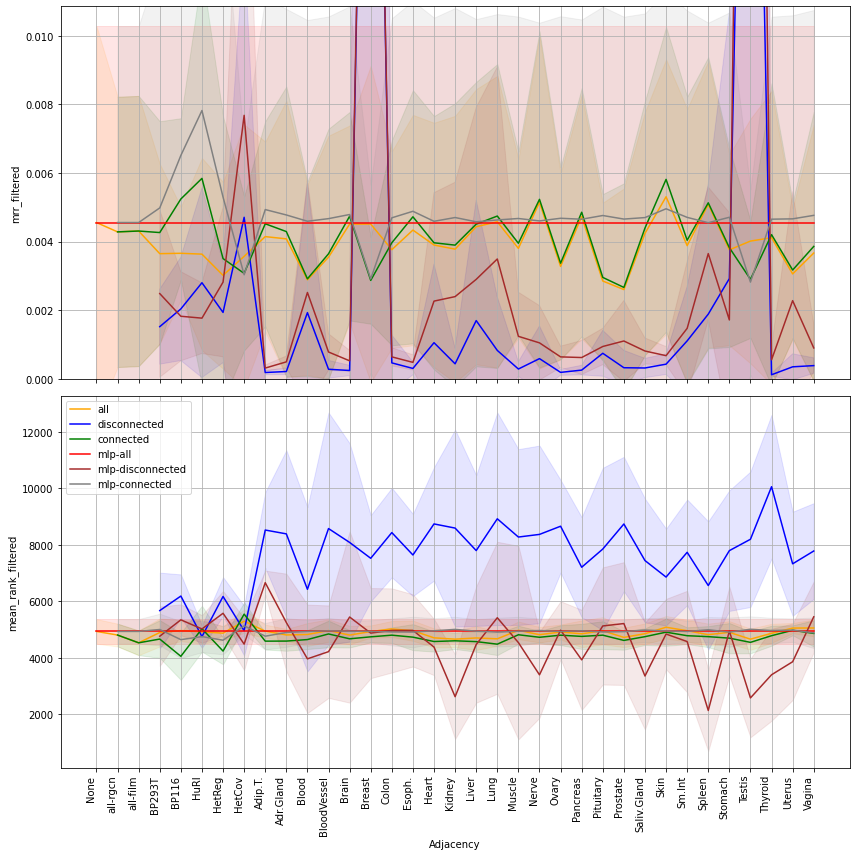

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["all","disconnected","connected","mlp-all","mlp-disconnected", "mlp-connected"]
adjs = ["None", "all-rgcn", "all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

num_folds = 4
repetitions = 4
num_metrics = 2
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "red",
          "brown",
          "grey"]

patches = {}

for k, df in enumerate([df_all, df_disconnected, df_connected, df_all_noadj, df_disconnected_noadj, df_connected_noadj]):
    step = num_folds * repetitions
    used_methods.append(methods[k])
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        if methods[k].endswith("all"):
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
            patches.update({k: patch})
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        else:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j][1:], color=colors[k])
            patches.update({k: patch})
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j][1:]-sds[:,j][1:], means[:,j][1:]+sds[:,j][1:], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')
        if "mrr" in df.columns[j]:
            ax.set_ylim(bottom=0)
        

fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

In [58]:
tb_concat = TestBench("testbench_adjacencies_parameters_tag.yaml", "testbench_config_adj_mr_immu_tag_concat.yaml")
tb_concat.config.inference.save_dir = "/localscratch/florin.ratajczak/results/"
tb_concat.compile_configs()

tb_concat.compile_resultshandlers()
tb_concat.configs = tb_concat.configs
tb_concat.resultshandlers = tb_concat.resultshandlers
tb_concat.parameter_list = tb_concat.parameter_list

tb_concat.metrics = ["mrr_filtered", "mean_rank_filtered"]
df_connected_concat = tb_concat.compare(save=False, additional_masks=np.array(connected_pos_only_masks).repeat(4,axis=0).tolist())
df_disconnected_concat = tb_concat.compare(save=False, additional_masks=np.array(disconnected_pos_only_masks).repeat(4, axis=0).tolist())
df_all_concat = tb_concat.compare(save=False)

OSError: [Errno 121] Unable to open file (unable to lock file, errno = 121, error message = 'Remote I/O error')

In [ ]:
tb_concat_noadj = TestBench("testbench_adjacencies_parameters_tag.yaml", "testbench_config_adj_mr_immu_tag_concat.yaml")
tb_concat.config.inference.save_dir = "/localscratch/florin.ratajczak/results/"
tb_concat_noadj.compile_configs()

tb_concat_noadj.compile_resultshandlers()
tb_concat_noadj.configs = tb_concat.configs
tb_concat_noadj.resultshandlers = tb_concat.resultshandlers[:4] * 35
tb_concat_noadj.parameter_list = tb_concat.parameter_list

tb_concat_noadj.metrics = ["mrr_filtered", "mean_rank_filtered"]
df_connected_concat_noadj = tb_concat_noadj.compare(save=False, additional_masks=np.array(connected_pos_only_masks).repeat(4,axis=0).tolist())
df_disconnected_concat_noadj = tb_concat_noadj.compare(save=False, additional_masks=np.array(disconnected_pos_only_masks).repeat(4, axis=0).tolist())
df_all_concat_noadj = tb_concat_noadj.compare(save=False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["all","disconnected","connected","mlp-all","mlp-disconnected", "mlp-connected"]
adjs = ["None", "all-rgcn", "all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

num_folds = 4
repetitions = 4
num_metrics = 2
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "red",
          "brown",
          "grey"]

patches = {}

for k, df in enumerate([df_all, df_disconnected, df_connected, df_all_noadj, df_disconnected_noadj, df_connected_noadj]):
    step = num_folds * repetitions
    used_methods.append(methods[k])
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        if methods[k].endswith("all"):
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
            patches.update({k: patch})
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        else:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j][1:], color=colors[k])
            patches.update({k: patch})
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j][1:]-sds[:,j][1:], means[:,j][1:]+sds[:,j][1:], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')
        if "mrr" in df.columns[j]:
            ax.set_ylim(bottom=0)
        

fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

In [8]:
hgncs_connected = [id2hgnc[key] for key in connected_positives]

In [16]:
old_disc_only_masks = disconnected_pos_only_masks[:]
old_conn_only_masks = connected_pos_only_masks[:]

In [29]:
disconnected_pos_only_masks = []
connected_pos_only_masks = []

connected_pos_only_mask = np.ones_like(experiment.dataset.data.y.cpu().detach().numpy())
if len(disconnected_positives) > 0:
    connected_pos_only_mask[disconnected_positives] = 0
connected_pos_only_masks.append(connected_pos_only_mask.astype(np.bool8))

disconnected_pos_only_mask = np.ones_like(experiment.dataset.data.y.cpu().detach().numpy())
if len(connected_positives) > 0:
    disconnected_pos_only_mask[connected_positives] = 0
disconnected_pos_only_masks.append(disconnected_pos_only_mask.astype(np.bool8))

In [30]:
connected_pos_only_masks = connected_pos_only_masks + old_conn_only_masks

In [57]:
del tb_concat
del tb_concat_noadj

NameError: name 'tb_concat_noadj' is not defined

In [33]:
disconnected_pos_only_masks = disconnected_pos_only_masks + old_disc_only_masks

In [44]:
disconnected_pos_only_masks

[array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ..

Did not find File: ../adjacencies_immu_graphsage_log_benchmark_adj_sage.tsv
Did not find File: ../adjacencies_immu_graphsage_concat_log_benchmark_adj_sage.tsv
Did not find File: ../adjacencies_immu_graphsage_skip_log_benchmark_adj_sage.tsv


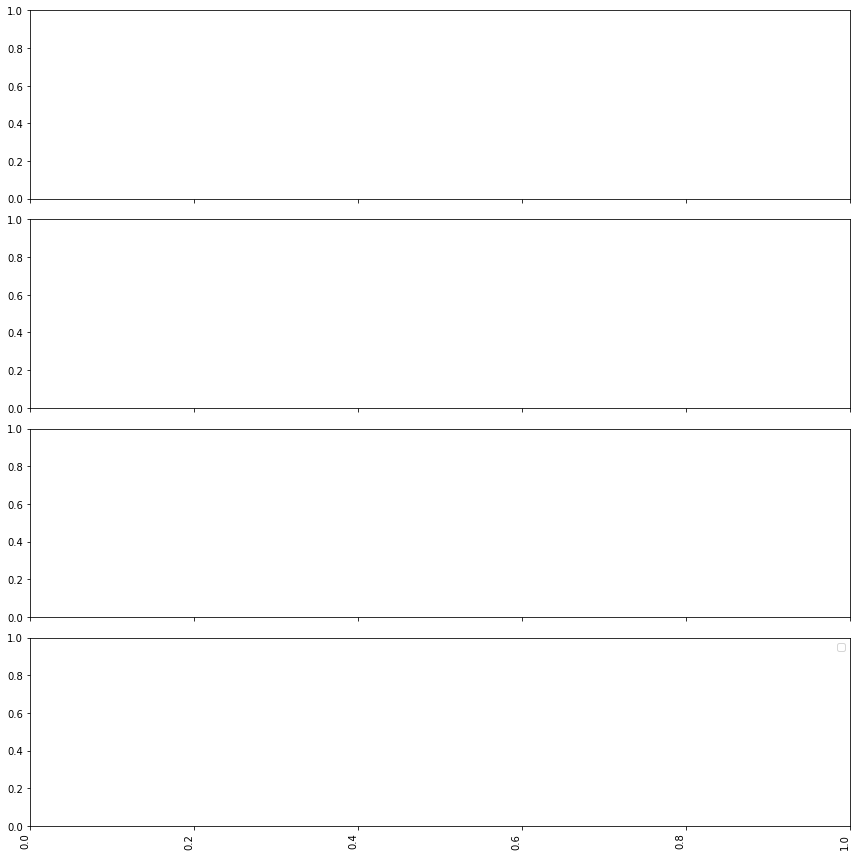

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "immu"

methods = ["normal","graphsage_concat","graphsage_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_{}_log_benchmark_adj_sage.tsv".format(toggle, method) for method in methods]
df_paths[0] = "../adjacencies_{}_graphsage_log_benchmark_adj_sage.tsv".format(toggle)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

Did not find File: ../adjacencies_cardio_graphsage_benchmark_adj_sage.tsv


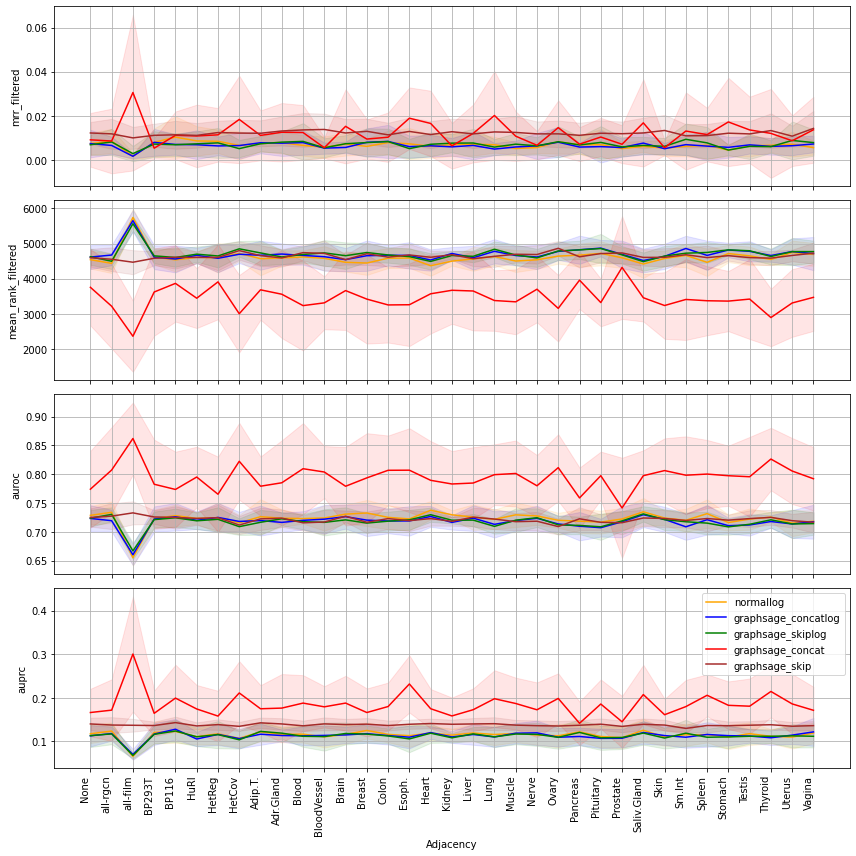

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "cardio"

methods = ["normal","graphsage_concat","graphsage_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_{}_log_benchmark_adj_sage.tsv".format(toggle, method) for method in methods]
df_paths[0] = "../adjacencies_{}_graphsage_log_benchmark_adj_sage.tsv".format(toggle)
df_paths += ["../adjacencies_{}_{}_benchmark_adj_sage.tsv".format(toggle, method) for method in methods]
df_paths[3] = "../adjacencies_{}_graphsage_benchmark_adj_sage.tsv".format(toggle)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        try:
            used_methods.append(methods[k] + "log")
        except IndexError:
            used_methods.append(methods[k-3])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

Did not find File: ../adjacencies_immu_tag_benchmark_adj_tag.tsv


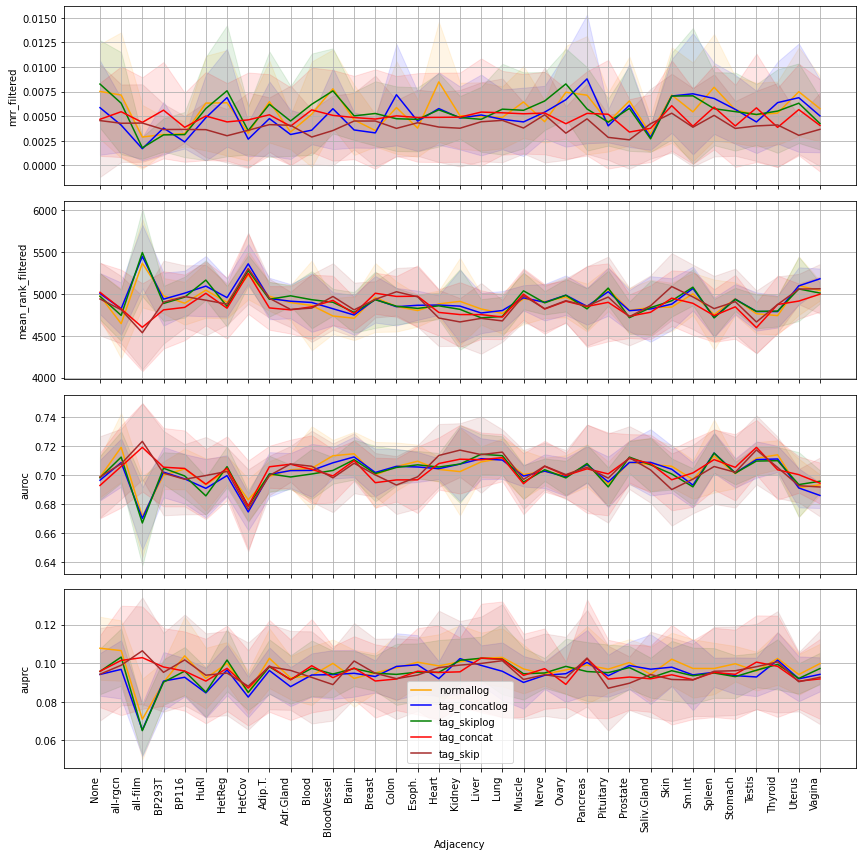

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "immu"

methods = ["normal","tag_concat","tag_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_{}_log_benchmark_adj_tag.tsv".format(toggle, method) for method in methods]
df_paths[0] = "../adjacencies_{}_tag_log_benchmark_adj_tag.tsv".format(toggle)
df_paths += ["../adjacencies_{}_{}_benchmark_adj_tag.tsv".format(toggle, method) for method in methods]
df_paths[3] = "../adjacencies_{}_tag_benchmark_adj_tag.tsv".format(toggle)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        try:
            used_methods.append(methods[k] + "log")
        except IndexError:
            used_methods.append(methods[k-3])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

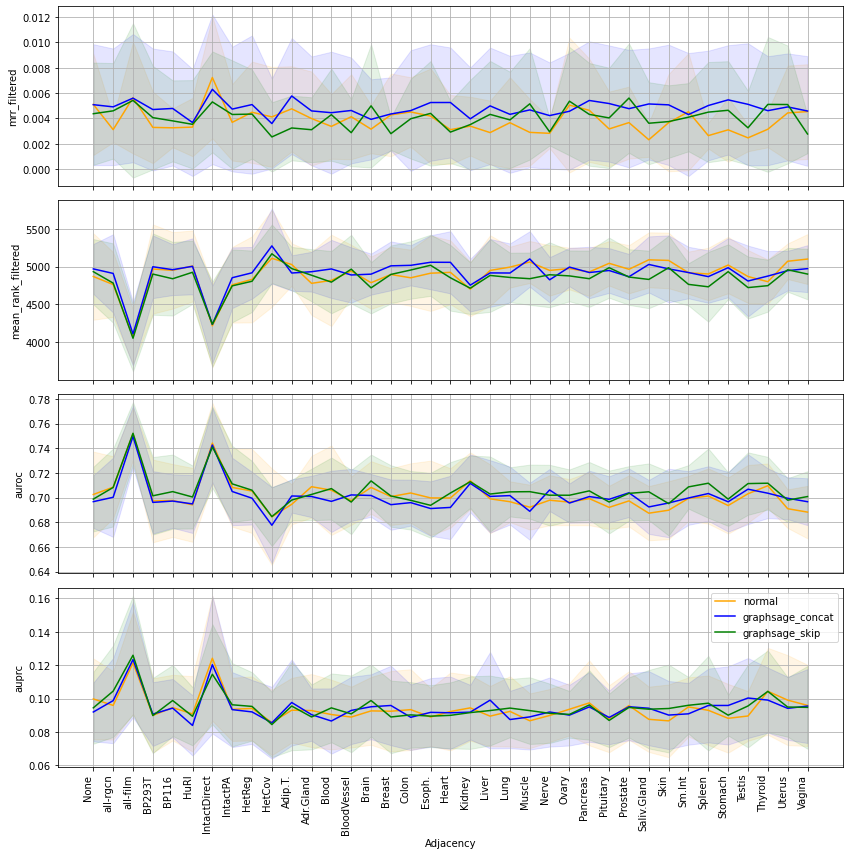

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "immu"
methods = ["normal","graphsage_concat","graphsage_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","IntactDirect","IntactPA","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_{}_benchmark_adj_sage_new.tsv".format(toggle, method) for method in methods]
df_paths[0] = "../adjacencies_{}_graphsage_benchmark_adj_sage_new.tsv".format(toggle)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

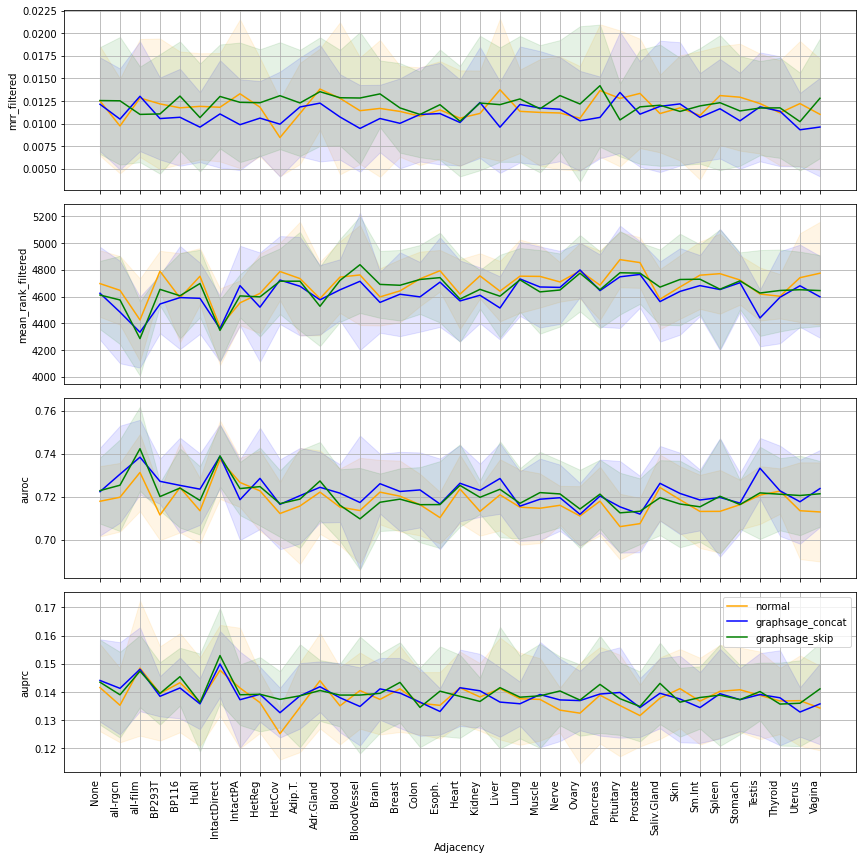

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "cardio"
methods = ["normal","graphsage_concat","graphsage_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","IntactDirect","IntactPA","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_{}_benchmark_adj_sage_new.tsv".format(toggle, method) for method in methods]
df_paths[0] = "../adjacencies_{}_graphsage_benchmark_adj_sage_new.tsv".format(toggle)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

                                                    mrr_filtered  \
adjacencies_immu_tag_benchmark_adj_tag_new_noad...      0.003625   
adjacencies_immu_tag_benchmark_adj_tag_new_noad...      0.003202   
adjacencies_immu_tag_benchmark_adj_tag_new_noad...      0.001736   
adjacencies_immu_tag_benchmark_adj_tag_new_noad...      0.011839   
adjacencies_immu_tag_benchmark_adj_tag_new_noad...      0.002273   
...                                                          ...   
adjacencies_immu_tag_benchmark_adj_tag_new_GRND...      0.005082   
adjacencies_immu_tag_benchmark_adj_tag_new_GRND...      0.001160   
adjacencies_immu_tag_benchmark_adj_tag_new_GRND...      0.004400   
adjacencies_immu_tag_benchmark_adj_tag_new_GRND...      0.001530   
adjacencies_immu_tag_benchmark_adj_tag_new_GRND...      0.002687   

                                                    mean_rank_filtered  \
adjacencies_immu_tag_benchmark_adj_tag_new_noad...         5324.676190   
adjacencies_immu_tag_benchmark_adj_

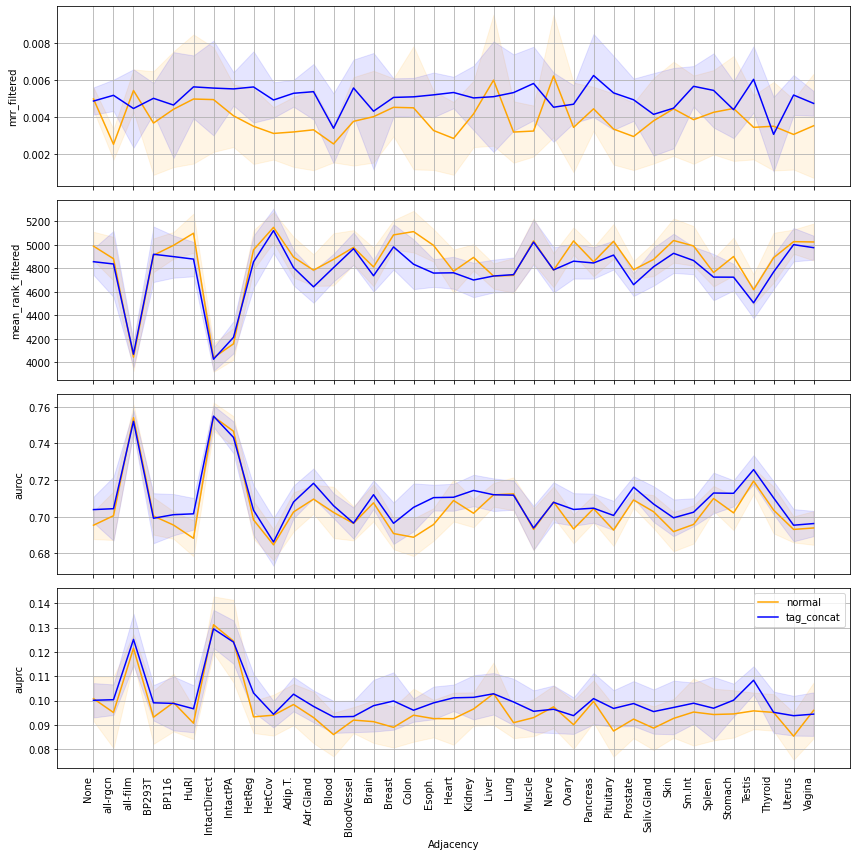

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "immu"
methods = ["normal","tag_concat","tag_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","IntactDirect","IntactPA","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_{}_benchmark_adj_tag_new.tsv".format(toggle, method) for method in methods]
df_paths[0] = "../adjacencies_{}_tag_benchmark_adj_tag_new.tsv".format(toggle)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    print(df)
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

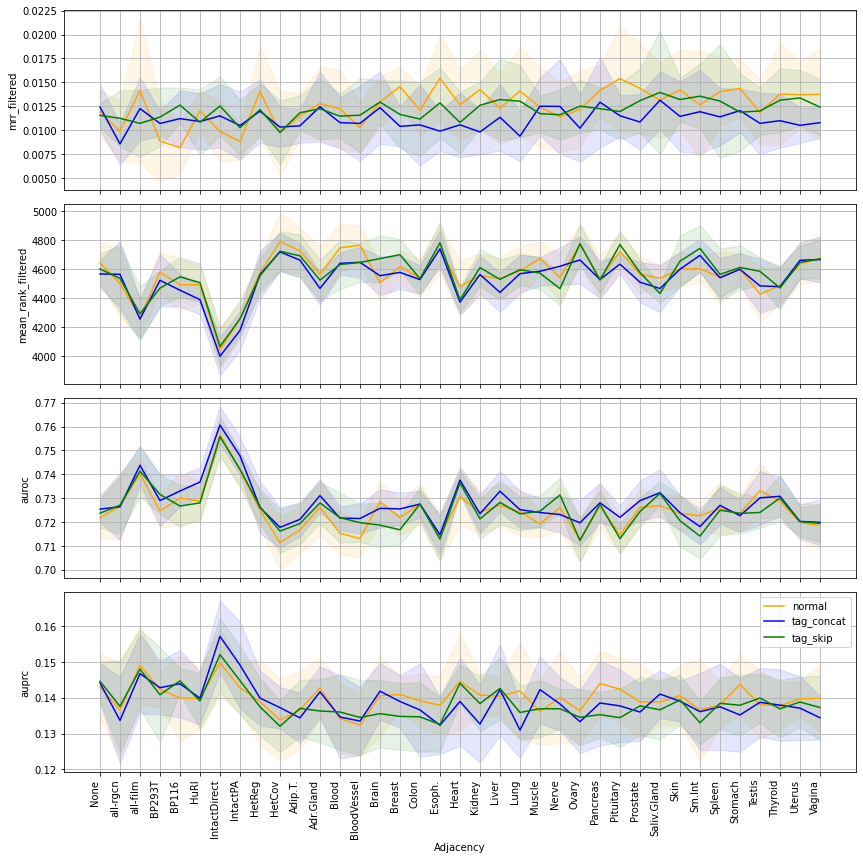

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "cardio"
methods = ["normal","tag_concat","tag_skip"]
adjs = ["None","all-rgcn","all-film","BP293T", "BP116","HuRI","IntactDirect","IntactPA","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_{}_benchmark_adj_tag_new.tsv".format(toggle, method) for method in methods]
df_paths[0] = "../adjacencies_{}_tag_benchmark_adj_tag_new.tsv".format(toggle)
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

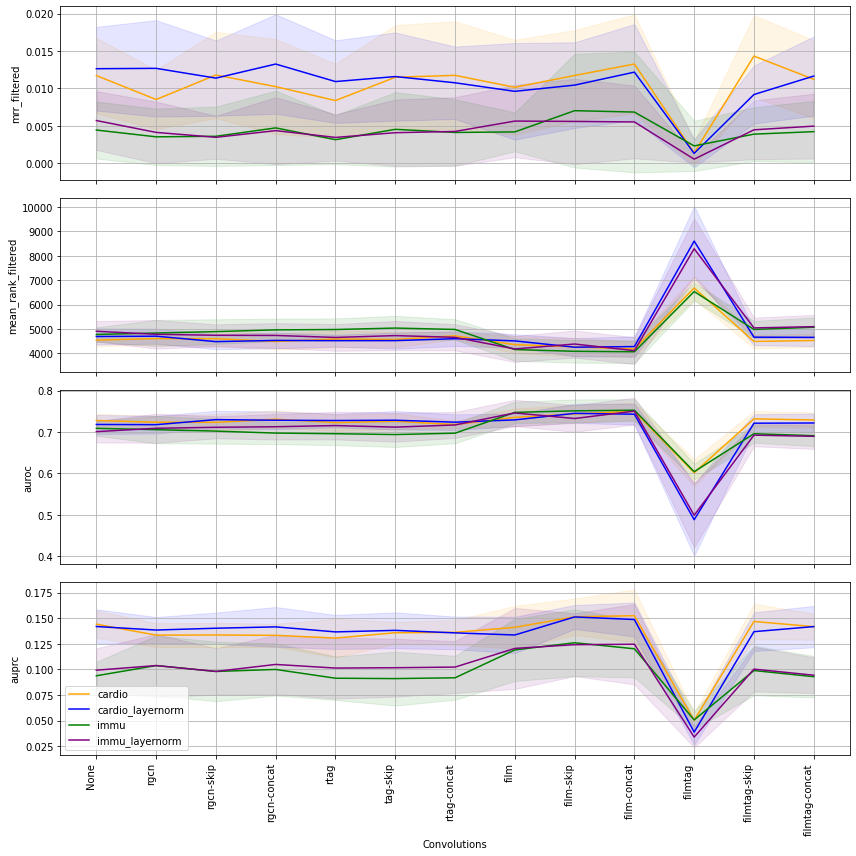

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

methods = ["cardio","cardio_layernorm","immu","immu_layernorm"]
adjs = ["None","rgcn","rgcn-skip","rgcn-concat", "rtag","tag-skip","rtag-concat","film","film-skip","film-concat","filmtag","filmtag-skip","filmtag-concat"]

df_paths = ["../adjacencies_all_{}_benchmark_all_adj.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Convolutions')


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/pandas/core/nanops.py:932: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/pandas/core/nanops.py:932: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


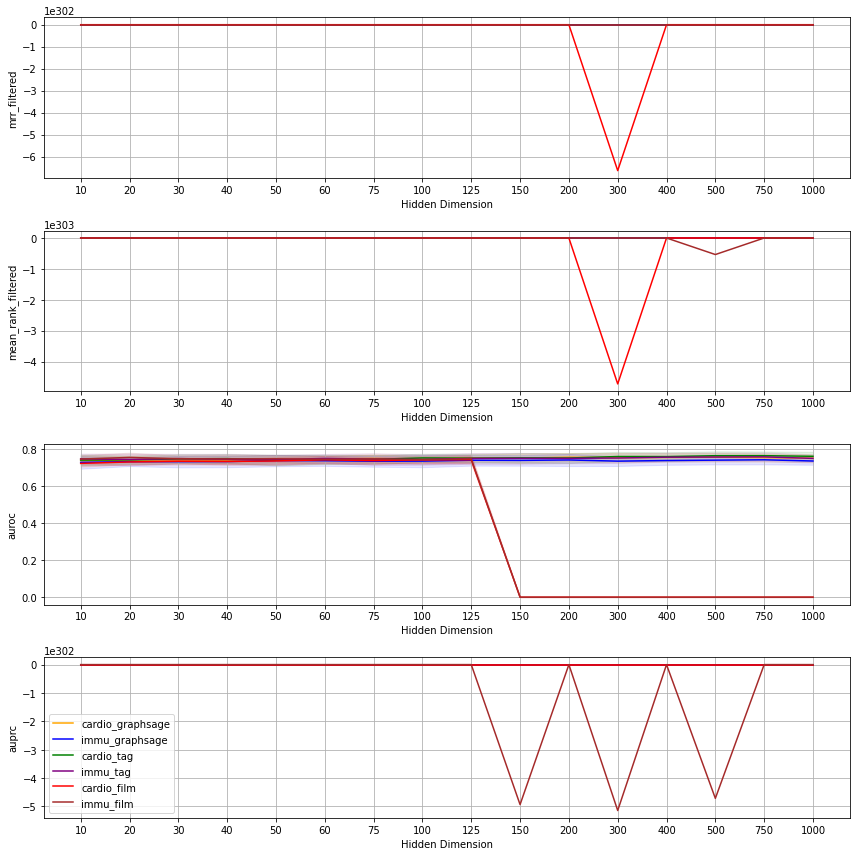

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggles = ["cardio", "immu"]
methods = ["graphsage","tag","film"]
adjs = [10,20,30,40,50,60,75,100,125,150,200,300,400,500,750,1000]
method_and_disease = [["{}_{}".format(toggle, method) for toggle in toggles] for method in methods]
method_and_disease = [path for sublist in method_and_disease for path in sublist]
methods = method_and_disease

df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12), sharex=False)
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Hidden Dimension')


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

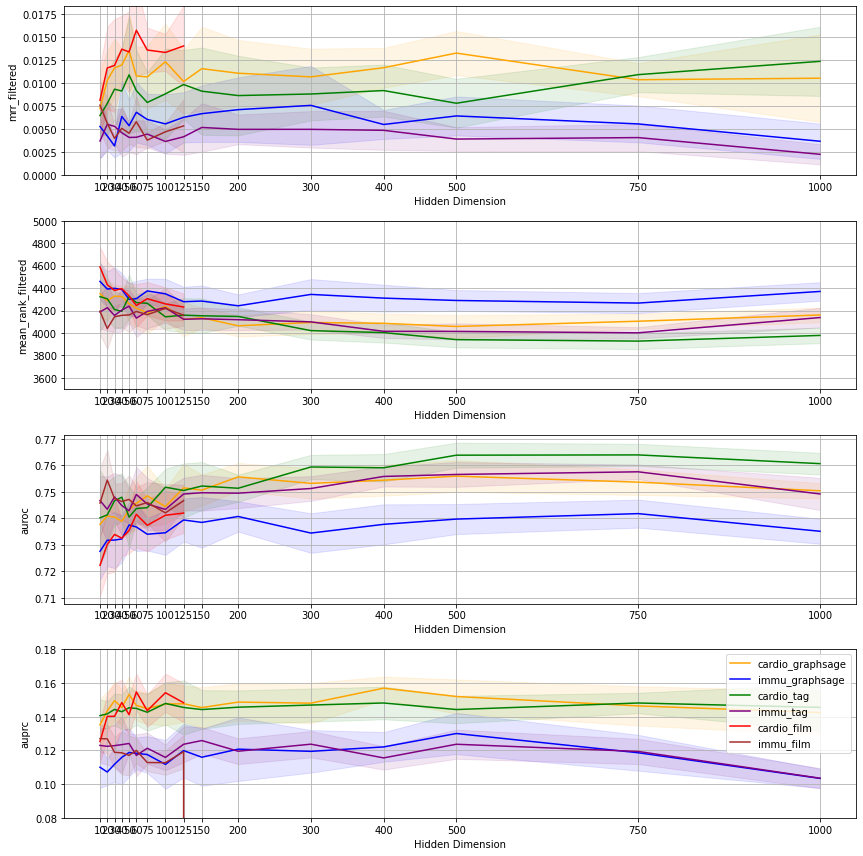

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggles = ["cardio", "immu"]
methods = ["graphsage","tag","film"]
adjs = [10,20,30,40,50,60,75,100,125,150,200,300,400,500,750,1000]
method_and_disease = [["{}_{}".format(toggle, method) for toggle in toggles] for method in methods]
method_and_disease = [path for sublist in method_and_disease for path in sublist]
methods = method_and_disease

df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12), sharex=False)
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue

    df[np.isclose(df, 0, atol=0.0001)] = np.nan
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(adjs, means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(adjs, means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(adjs, adjs)
        ax.set_xlabel('Hidden Dimension')
        if "mrr" in df.columns[j]:
            ax.set_ylim(bottom=0)
        if "mean_rank" in df.columns[j]:
            ax.set_ylim((3500,5000))
        if "auprc" in df.columns[j]:
            ax.set_ylim((0.08,0.18))


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

592
37
592
37
592
37
592
37
592
37
592
37


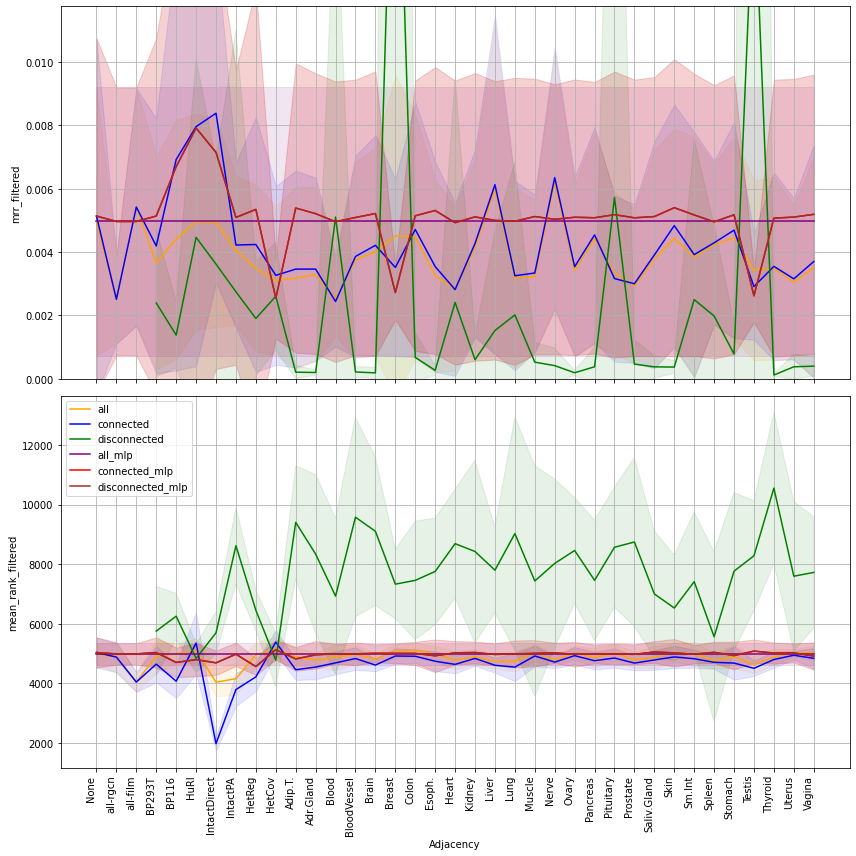

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

toggle = "immu"
methods = ["all","connected","disconnected"] # , "all_mlp", "connected_mlp", "disconnected_mlp"]
adjs = ["None","all-rgcn","all-film","BP293T","BP116","HuRI","IntactDirect","IntactPA","HetReg","HetCov","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

df_paths = ["../adjacencies_{}_tag_benchmark_adj_tag_new_{}.tsv".format(toggle, method) for method in methods]
num_folds = 4
repetitions = 4
num_metrics = 2
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12))
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    print(len(df))
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
    print(len(means))
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')
        if "mrr" in df.columns[j]:
            ax.set_ylim(bottom=0)


fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

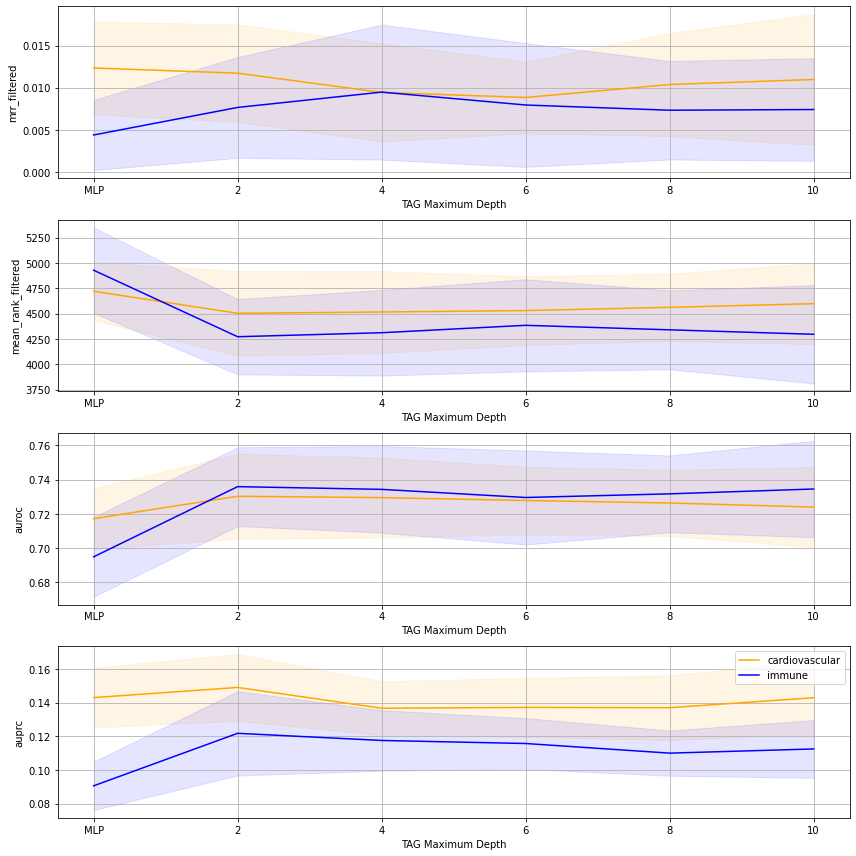

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline


methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../ablation_{}_benchmark_tag_depth.tsv".format(method) for method in methods]
adjs = ["MLP",2,4,6,8,10]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12), sharex=False)
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = one_run.std(axis=0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('TAG Maximum Depth')


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

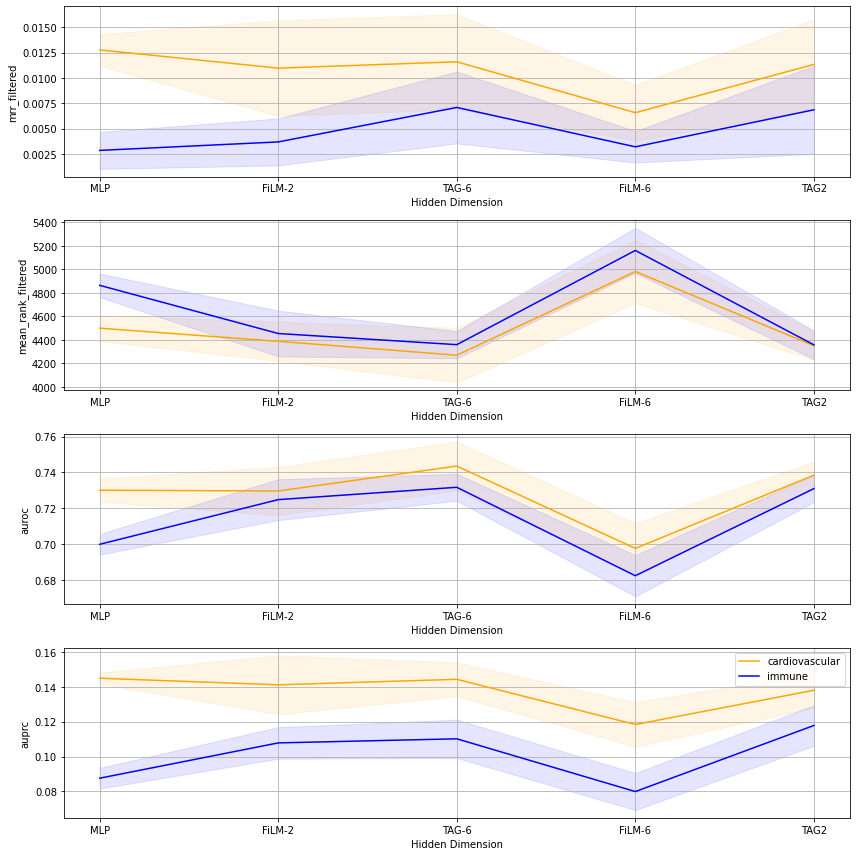

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline


methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../ablation_{}_benchmark_ablation.tsv".format(method) for method in methods]
adjs = ["MLP","FiLM-2","TAG-6","FiLM-6","TAG2"]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12), sharex=False)
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        #sds[i,:] = one_run.std(axis=0)
        sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Hidden Dimension')


plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

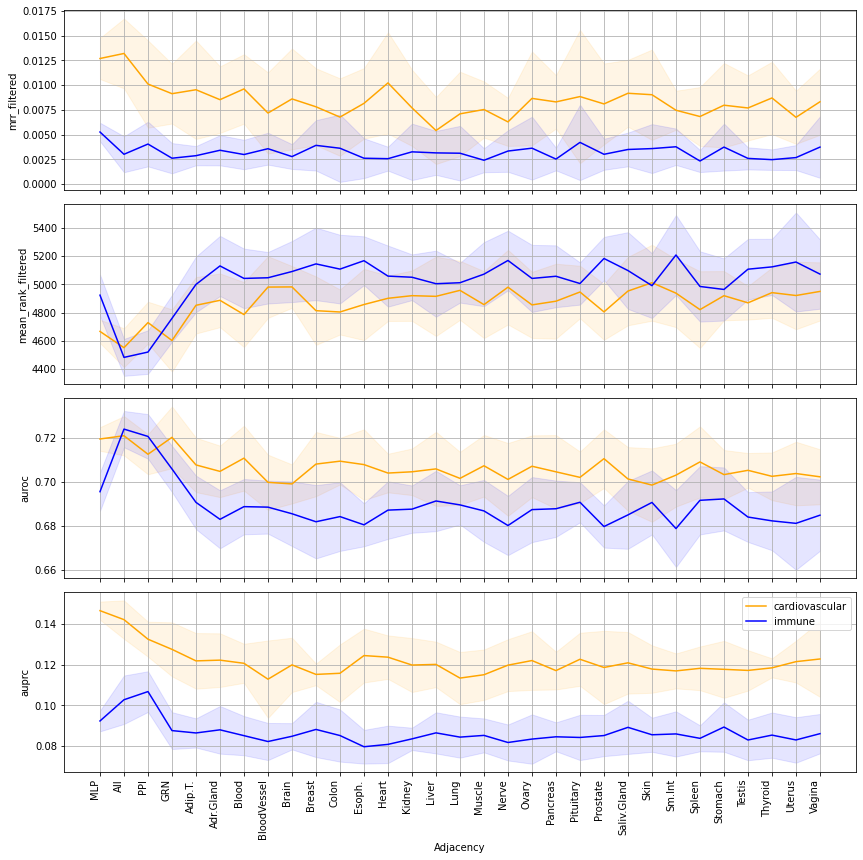

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline


methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../grn_{}_benchmark_grn.tsv".format(method) for method in methods]
adjs = ["MLP","All","PPI","GRN","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]
num_folds = 4
repetitions = 4
num_metrics = 4
fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12), sharex=False)
used_methods = []
colors = ["orange",
          "blue",
          "green",
          "purple",
          "red",
          "brown",
          "pink",
          "grey"]
patches = {}

for k, df_path in enumerate(df_paths):
    step = num_folds * repetitions
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
        continue
    means = np.empty((len(df.index) // step, len(df.columns)))
    sds = np.empty((len(df.index) // step, len(df.columns)))
    maxes = np.empty((len(df.index) // step, len(df.columns)))
    mins = np.empty((len(df.index) // step, len(df.columns)))
   
    for i, start in enumerate(range(0, len(df.index), step)):
        one_run = df[start:(start + step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)

    for j, ax in enumerate(axes):
        try:
            patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
        except ValueError:
            patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
        patches.update({k: patch})
        try:
            ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        except ValueError:
            ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(df.columns[j])
        ax.grid(True)
        ax.set_xticks(list(range(len(adjs))), adjs)
        ax.set_xlabel('Adjacency')

fig.autofmt_xdate(rotation=90)
plt.legend(list(patches.values()), used_methods)
plt.tight_layout()
plt.show()

In [2]:
def plot_results(methods, paths, x_label, x_tick_labels, rotate_x_tick_labels: bool = False, num_folds: int = 4, num_repetitions: int = 4, num_metrics = None):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from matplotlib import rc
    #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    #rc('font',**{'family':'serif','serif':['Times']})
    #rc('text', usetex=False)

    colors = ["orange",
              "blue",
              "green",
              "purple",
              "red",
              "brown",
              "pink",
              "grey"]

    abbreviations = {"mrr": "MRR",
                     "auroc": "AUROC",
                     "auprc": "AUPRC"}

    if num_metrics is None:
        for path in paths:
            try:
                df = pd.read_csv(paths[0], sep="\t", header=0, index_col=0)
                num_metrics = len(df.columns)
                break
            except FileNotFoundError:
                print("Did not find File: {}".format(path))

    fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 12), sharex=False)

    used_methods = []

    patches = {}

    for k, df_path in enumerate(df_paths):
        step = num_folds * num_repetitions
        try:
            df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
            used_methods.append(methods[k])
        except FileNotFoundError:
            print("Did not find File: {}".format(df_path))
            
        means = np.empty((len(df.index) // step, len(df.columns)))
        sds = np.empty((len(df.index) // step, len(df.columns)))
        maxes = np.empty((len(df.index) // step, len(df.columns)))
        mins = np.empty((len(df.index) // step, len(df.columns)))
    
        for i, start in enumerate(range(0, len(df.index), step)):
            one_run = df[start:(start + step)]
            means[i,:] = one_run.mean(axis=0)
            sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
            maxes[i,:] = one_run.max(axis=0)
            mins[i,:] = one_run.min(axis=0)

        for j, ax in enumerate(axes):
            try:
                patch, = ax.plot(list(range(len(adjs))), means[:,j], color=colors[k])
            except ValueError:
                patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
            patches.update({k: patch})
            try:
                ax.fill_between(list(range(len(adjs))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
            except ValueError:
                ax.fill_between(list(range(len(adjs))[1:]), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
            #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
            ax.set_ylabel(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
            ax.grid(True)
            ax.set_xticks(list(range(len(adjs))), adjs)
            ax.set_xlabel(x_label)

    if rotate_x_tick_labels:
        fig.autofmt_xdate(rotation=90)
    plt.legend(list(patches.values()), used_methods)
    plt.tight_layout()

    return fig, axes



In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../grn_{}_benchmark_grn.tsv".format(method) for method in methods]
adjs = ["MLP","All","PPI","GRN","Adip.T.","Adr.Gland","Blood","BloodVessel","Brain", "Breast","Colon","Esoph.","Heart","Kidney","Liver","Lung","Muscle","Nerve","Ovary","Pancreas","Pituitary","Prostate","Saliv.Gland","Skin","Sm.Int","Spleen","Stomach","Testis","Thyroid","Uterus","Vagina"]

fig, axes = plot_results(methods, df_paths, x_label='Adjacency', x_tick_labels=adjs, rotate_x_tick_labels=True)
plt.show()

In [2]:
import matplotlib.font_manager

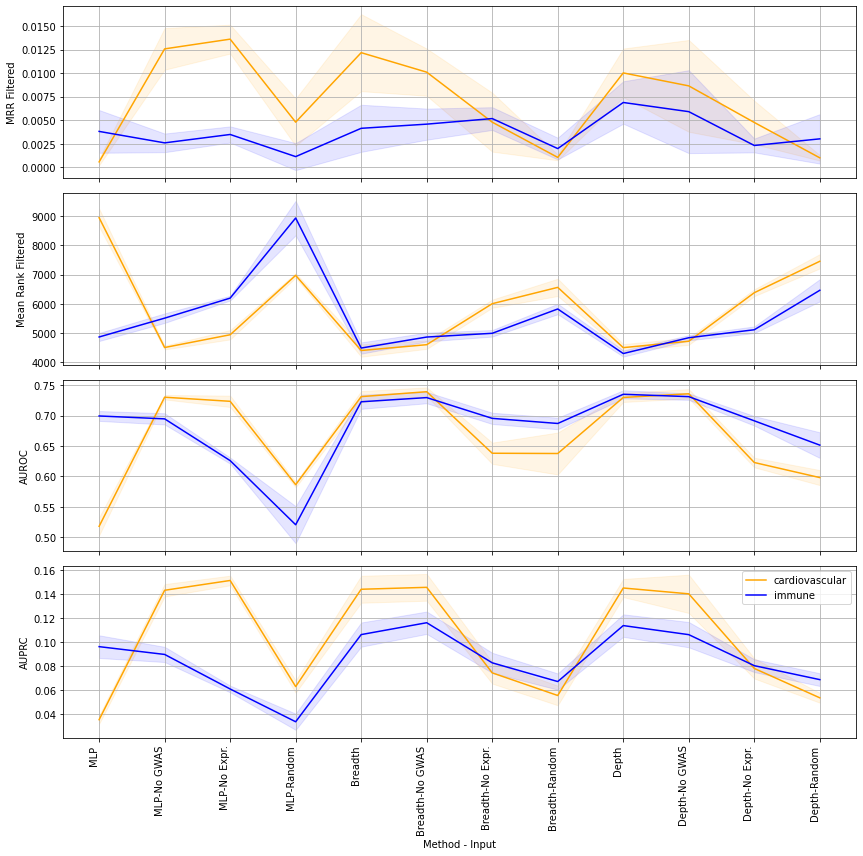

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../input_{}_benchmark_input_ablation.tsv".format(method) for method in methods]
adjs = ["MLP", "MLP-No GWAS", "MLP-No Expr.", "MLP-Random","Breadth", "Breadth-No GWAS", "Breadth-No Expr.", "Breadth-Random","Depth", "Depth-No GWAS", "Depth-No Expr.", "Depth-Random"]

fig, axes = plot_results(methods, df_paths, x_label='Method - Input', x_tick_labels=adjs, rotate_x_tick_labels=True)
plt.show()

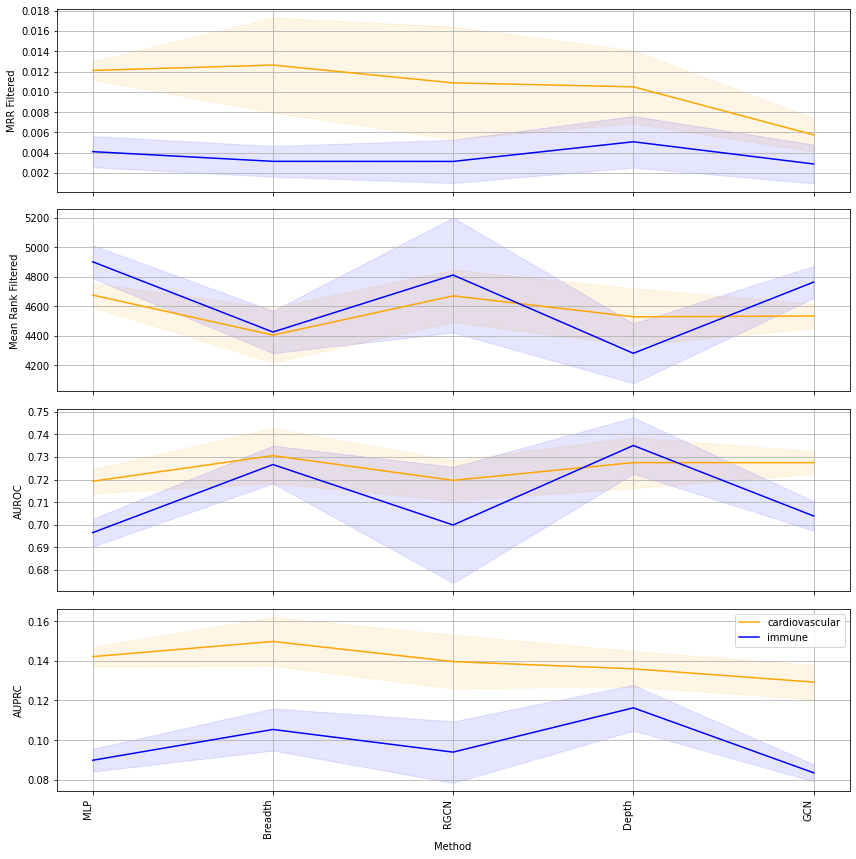

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../input_{}_benchmark_ablation_basics.tsv".format(method) for method in methods]
adjs = ["MLP", "Breadth", "RGCN", "Depth","GCN"]

fig, axes = plot_results(methods, df_paths, x_label='Method', x_tick_labels=adjs, rotate_x_tick_labels=True)
plt.show()

In [21]:
crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
purple = "#3c1361"

def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

light_crimson = colorFader(crimson, mix=0.1)
light_jungle = colorFader(jungle, mix=0.1)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

phenos = ["cardiovascular", "immune"]
ml_methods = ["breadth", "depth"]
methods = ["{}_{}".format(method, pheno) for method in ml_methods for pheno in phenos]
#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../ablation_{}_benchmark_ablation_randadj.tsv".format(method,) for method in methods]
adjs = ["100-0","100-1","100-2","100-3","100-4","75-0","75-1","75-2","75-3","75-4","50-0","50-1","50-2","50-3","50-4","25-0","25-1","25-2","25-3","25-4", "Normal", "MLP"]

x_label = ["MLP", "0%", "25%", "50%", "75%", "100%"]

#fig, axes = plot_results(methods, df_paths, x_label='Method', x_tick_labels=adjs, rotate_x_tick_labels=True)

num_folds = 4
num_repetitions = [16, 16, 16, 16, 4, 4]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
    #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    #rc('font',**{'family':'serif','serif':['Times']})
    #rc('text', usetex=False)

colors = [light_crimson,
        light_jungle,
        light_crimson,
        light_jungle,
]

linestyles = ["dashed","dashed", "dotted", "dotted"]


abbreviations = {"mrr": "MRR",
                     "auroc": "AUROC",
                     "auprc": "AUPRC"}

num_metrics = 2

if num_metrics is None:
    for path in df_paths:
        try:
            df = pd.read_csv(df_paths[0], sep="\t", header=0, index_col=0)
            num_metrics = len(df.columns)
            break
        except FileNotFoundError:
            print("Did not find File: {}".format(path))

fig, axes = plt.subplots(num_metrics, 1, figsize=(6, 6), sharex=False)
legend = ["Breadth Cardiovascular Disease", "Breadth Immune Dysregulation", "Depth Cardiovascular Disease", "Depth Immune Dysregulation"]
used_methods = []

patches = {}

for k, df_path in enumerate(df_paths):
    print(df_path)
    step = [num_folds * num_repetition for num_repetition in num_repetitions]
    try:
        df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
        #df.drop(["mrr_filtered", "mean_rank_filtered"], axis=1, inplace=True)
        used_methods.append(methods[k])
    except FileNotFoundError:
        print("Did not find File: {}".format(df_path))
            
    means = np.empty((6, len(df.columns)))
    sds = np.empty((6, len(df.columns)))
    maxes = np.empty((6, len(df.columns)))
    mins = np.empty((6, len(df.columns)))
    
    next_step = step[0]
    for i, start in enumerate(range(0, len(df.index), next_step)):
        one_run = df[start:(start + next_step)]
        means[i,:] = one_run.mean(axis=0)
        sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
        maxes[i,:] = one_run.max(axis=0)
        mins[i,:] = one_run.min(axis=0)
        try:
            next_step = step[i + 1]
        except IndexError:
            continue

    means = np.flip(means, axis=0)
    sds = np.flip(sds, axis=0)
    maxes = np.flip(maxes, axis=0)
    mins = np.flip(mins, axis=0)

    for j, ax in enumerate(axes):
        patch, = ax.plot(list(range(len(x_label))), means[:,j], color=colors[k], ls=linestyles[k])

        patches.update({k: patch})
        ax.fill_between(list(range(len(x_label))), means[:,j]-sds[:,j], means[:,j]+sds[:,j], color=colors[k], alpha=0.1, zorder=-1)
        #ax.fill_between(list(range(len(adjs))), mins[:,j], maxes[:,j], color=colors[k], alpha=0.1, zorder=-1)
        ax.set_ylabel(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
        if df.columns[j] == "auroc":
            ax.set_ylim((0.71, 0.78))
        elif df.columns[j] == "auprc":
            ax.set_ylim((0.08, 0.20))
        ax.grid(True)
        ax.set_xticks(list(range(len(x_label))), x_label)
        ax.set_xlabel("Network Rewiring")
        ax.legend(list(patches.values()), legend)


plt.tight_layout()
plt.savefig("Ablation_Adjacency.png", dpi=400)


: 

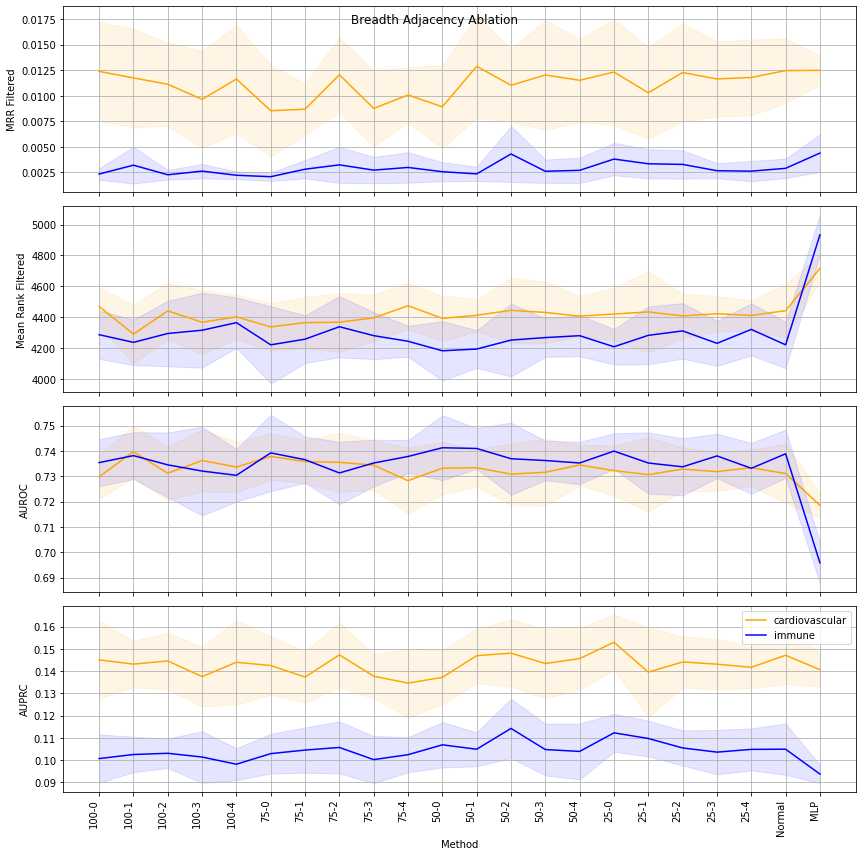

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../ablation_breadth_{}_benchmark_ablation_randadj.tsv".format(method) for method in methods]
adjs = ["100-0","100-1","100-2","100-3","100-4","75-0","75-1","75-2","75-3","75-4","50-0","50-1","50-2","50-3","50-4","25-0","25-1","25-2","25-3","25-4", "Normal", "MLP"]

fig, axes = plot_results(methods, df_paths, x_label='Method', x_tick_labels=adjs, rotate_x_tick_labels=True)
fig.suptitle("Breadth Adjacency Ablation")
plt.show()

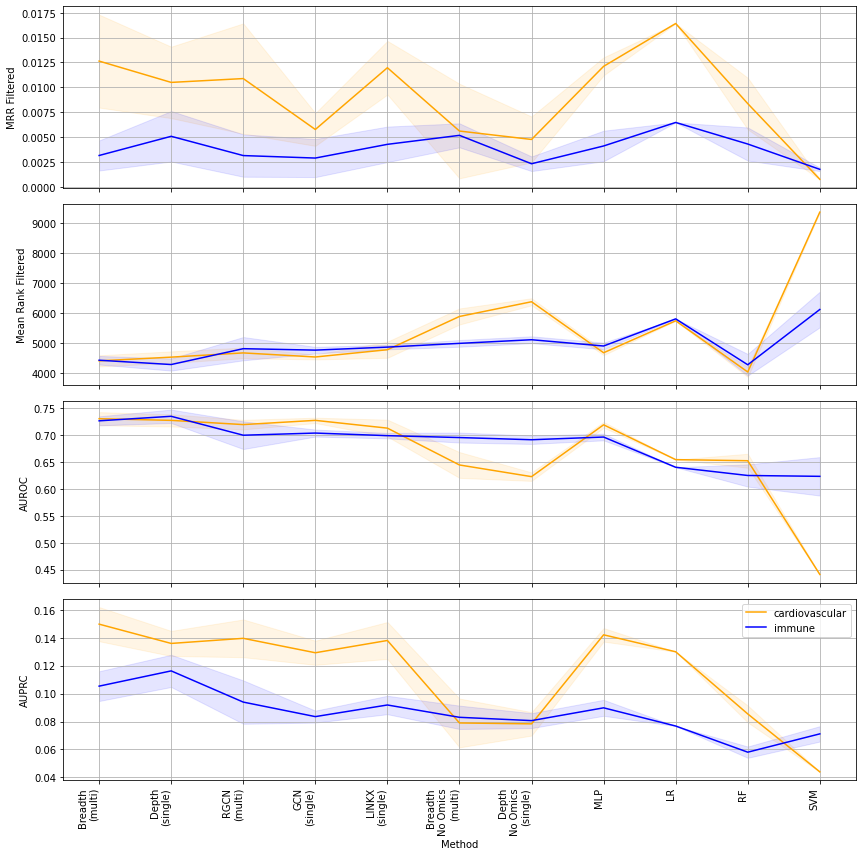

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

methods = ["cardiovascular","immune"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../sklearn_{}_sklearn_benchmark.tsv".format(method) for method in methods]
adjs = ["Breadth\n(multi)", "Depth\n(single)", "RGCN\n(multi)", "GCN\n(single)", "LINKX\n(single)", "Breadth\nNo Omics\n(multi)", "Depth\nNo Omics\n(single)", "MLP", "LR", "RF", "SVM"]

fig, axes = plot_results(methods, df_paths, x_label='Method', x_tick_labels=adjs[::-1], rotate_x_tick_labels=True)
#fig.suptitle("Breadth Adjacency Ablation")
plt.show()

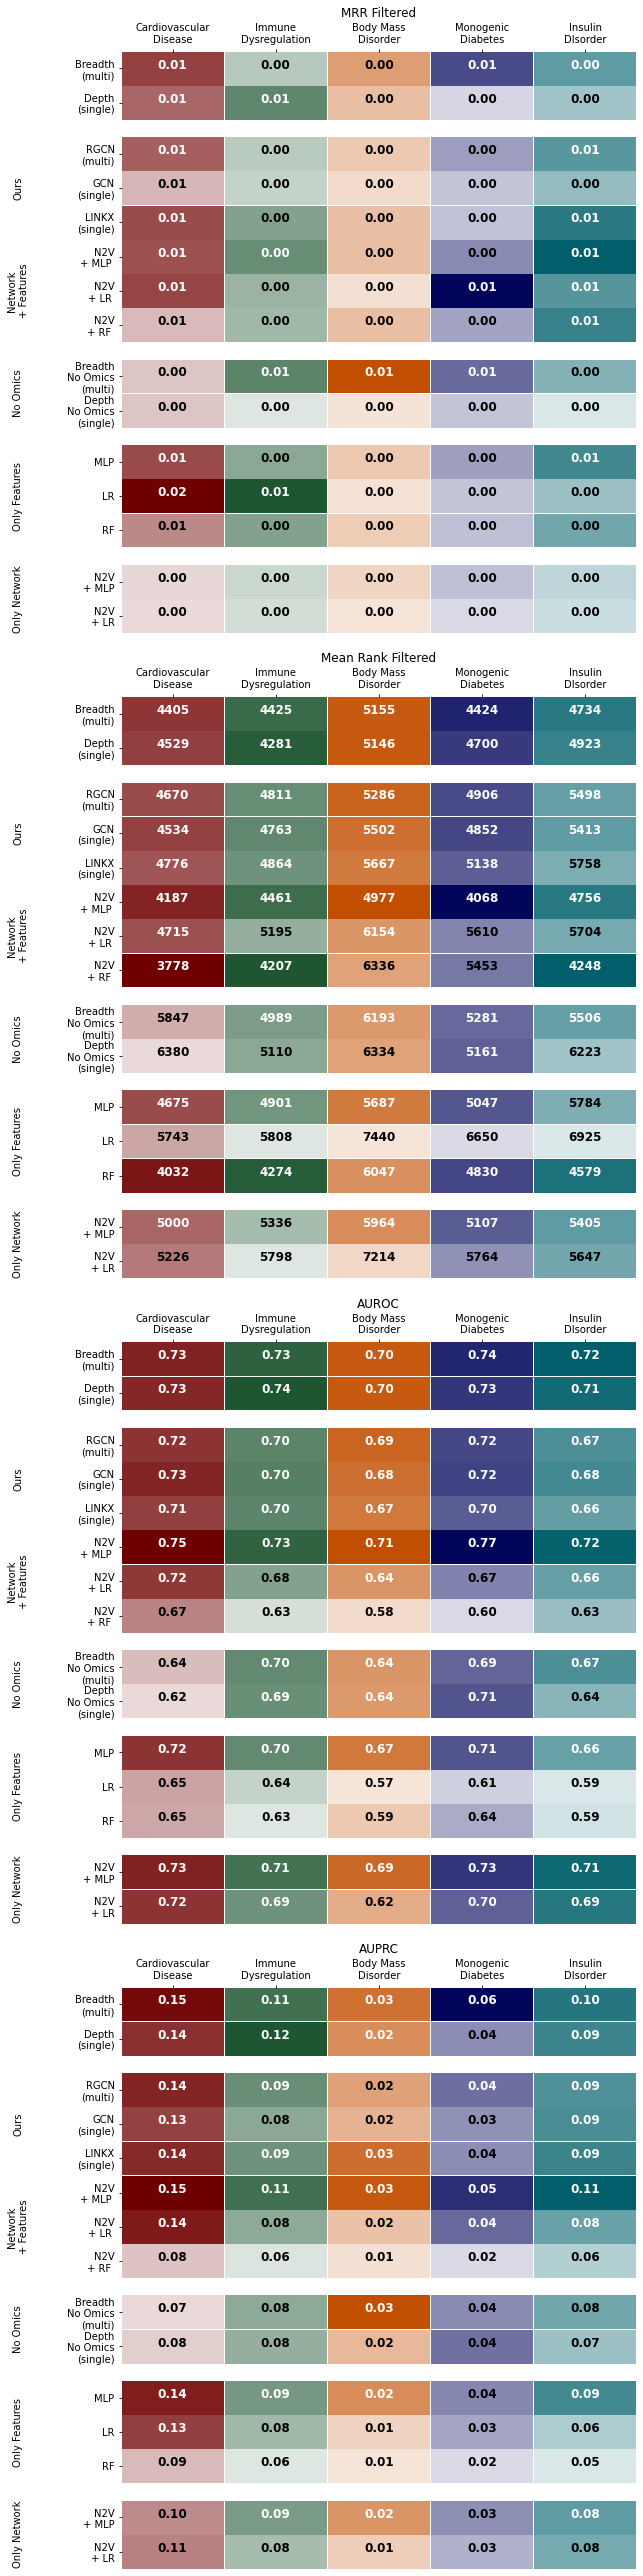

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

methods = ["cardiovascular","immune","bm_disorder","diabetes","insulin_disorder"]

#df_paths = ["../nhid_{}_benchmark_nhid_new.tsv".format(method) for method in methods]
df_paths = ["../final_benchmarks/{}_benchmark.tsv".format(method) for method in methods]
adjs = ["Breadth\n(multi)", "Depth\n(single)", "break", "RGCN\n(multi)", "GCN\n(single)", "LINKX\n(single)","N2V\n+ MLP ", "N2V\n+ LR ", "N2V\n+ RF ", "break", "Breadth\nNo Omics\n(multi)", "Depth\nNo Omics\n(single)", "break", "MLP", "LR", "RF", "break", "N2V\n+ MLP", "N2V\n+ LR"]

fig, axes = plot_results_matrix(methods, df_paths, y_label='Method', y_tick_labels=adjs[::-1], x_tick_labels=["Cardiovascular\nDisease", "Immune\nDysregulation", "Body Mass\nDisorder", "Monogenic\nDiabetes", "Insulin\nDIsorder"])
#fig.suptitle("Breadth Adjacency Ablation")
plt.savefig("final_benchmark.png", dpi=300)
#plt.show()

In [2]:
def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def plot_results_matrix(methods, paths, y_label, y_tick_labels, x_tick_labels, num_folds: int = 4, num_repetitions: int = 4, num_metrics = None):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from matplotlib import rc
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    width = 1 - border_size
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    abbreviations = {"mrr": "MRR",
                     "auroc": "AUROC",
                     "auprc": "AUPRC"}

    if num_metrics is None:
        for path in paths:
            try:
                df = pd.read_csv(paths[0], sep="\t", header=0, index_col=0)
                num_metrics = len(df.columns)
                metrics = df.columns
                break
            except FileNotFoundError:
                print("Did not find File: {}".format(path))

    fig, axes = plt.subplots(num_metrics, 1, figsize=(1.5 + (1.5*len(x_tick_labels)), 9*num_metrics), sharex=False)

    used_methods = []

    patches = {}

    for k, df_path in enumerate(df_paths):
        step = num_folds * num_repetitions
        try:
            df = pd.read_csv(df_path, sep="\t", header=0, index_col=0)
            used_methods.append(methods[k])
        except FileNotFoundError:
            print("Did not find File: {}".format(df_path))
            
        means = np.empty((len(df.index) // step, len(df.columns)))
        sds = np.empty((len(df.index) // step, len(df.columns)))
        maxes = np.empty((len(df.index) // step, len(df.columns)))
        mins = np.empty((len(df.index) // step, len(df.columns)))
    
        for i, start in enumerate(range(0, len(df.index), step)):
            one_run = df[start:(start + step)]
            means[i,:] = one_run.mean(axis=0)
            sds[i,:] = np.mean([one_run.iloc[j::4].std(axis=0) for j in range(num_folds)], axis = 0)
            maxes[i,:] = one_run.max(axis=0)
            mins[i,:] = one_run.min(axis=0)

        for j, ax in enumerate(axes):
            methods_without_breaks = [label for label in y_tick_labels[::-1] if label != "break"]
            for num_method, method in enumerate(y_tick_labels):
                #patch, = ax.plot(list(range(len(adjs)))[1:], means[:,j], color=colors[k])
                height = break_height if method == "break" else regular_height
                minmax_means = (means[:,j] - np.min(means[:,j])) / (np.max(means[:,j]) - np.min(means[:,j]))
                if df.columns[j] == "mean_rank_filtered":
                    color = "w" if method == "break" else color_gradients[k][int(100 * (1 - minmax_means[methods_without_breaks.index(method)]))]
                else:
                    color = "w" if method == "break" else color_gradients[k][int(100 * minmax_means[methods_without_breaks.index(method)])]
                bottom = np.sum([break_height if _method == "break" else regular_height for _method in y_tick_labels[:num_method]])
                ax.bar(k, height=height - border_size, bottom=bottom,
                        color=color, width=width)
                
                if method != "break":
                    if df.columns[j] == "mean_rank_filtered":
                        color = "w" if minmax_means[methods_without_breaks.index(method)] < 0.5 else "black"
                        text = str(int(means[methods_without_breaks.index(method),j]))
                    else:
                        color = "w" if minmax_means[methods_without_breaks.index(method)] > 0.5 else "black"
                        text = "{:.2f}".format(means[methods_without_breaks.index(method),j])
                    
                    ax.text(k, bottom + (0.5*height), text, ha='center',
                                weight='bold', size=12, color=color)

    for j, ax in enumerate(axes):
        yticks = []
        for index in range(len(y_tick_labels)):
            yticks.append(np.sum([break_height if label == "break" else regular_height for label in y_tick_labels[:index + 1]]) - 0.5)

        ax.set_title(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
        ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in y_tick_labels], dtype = np.bool8)])
        ax.set_yticklabels([label for label in y_tick_labels if label != "break"])
        
        ax.set_xticks(range(len(x_tick_labels)))
        ax.set_xticklabels(x_tick_labels)

        for location, text in zip([1, 4, 7, 10, 13], ["Only Network", "Only Features", "No Omics", "Network\n+ Features", "Ours"]):
            ax.text(-1.5, location, text, rotation=90, ha='center', va="center")

        ax.xaxis.set_ticks_position('top')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in y_tick_labels]) - border_size))
        ax.set_xlim((- width/2, len(paths) - ((width/2) + border_size)))

    plt.tight_layout()

    return fig, axes

In [21]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes")

from coregenes.utils.config import Config
from coregenes.postprocessing.postprocessor import PostProcessor

In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt

def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)



diseases = ["cardiovascular", "immune_dysregulation"]
pretty_diseases = ["Cardiovascular Disease", "Immune Dysregulation"]
methods = ["film", "tag"]
pretty_methods = ["Breadth", "Depth"]

disease_ors = {disease: None for disease in pretty_diseases}
disease_pvals = {disease: None for disease in pretty_diseases}


for disease, pretty_disease in zip(diseases, pretty_diseases):
    for method, pretty_method in zip(methods, pretty_methods):
        if disease == "immune_dysregulation" and method == "film":
            method = "film_forreal"

        config = Config()
        config.parse_yaml("/home/icb/florin.ratajczak/ppi-core-genes/config_{}_{}.yaml".format(disease, method))
        
        pp = PostProcessor(config)

        outer_results = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}outer_results.json".format(disease, method)
        results_file = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}_outer_0_fold_1.tsv".format(disease, method)

        with open(outer_results, "r") as file:
            outer_results = json.load(file)

        pp.outer_result = outer_results

        results = pp.dge(results_file)
        if disease_ors[pretty_disease] is None:
            disease_ors[pretty_disease] = pd.DataFrame(data=results["mendelian_odds_ratios"].values, index=results.index, columns=["Mendelian"])
            disease_pvals[pretty_disease] = pd.DataFrame(data=results["mendelian_pvals"].values, index=results.index, columns=["Mendelian"])
        disease_ors[pretty_disease][pretty_method] = results["candidate_odds_ratios"].values
        disease_pvals[pretty_disease][pretty_method] = results["candidate_pvals"].values


print(disease_ors["Cardiovascular Disease"].transpose())


cardiovascular_film 2022-08-03 10:29:12,204 [INFO] coregenes.postprocessing.postprocessor: Starting Differential Gene Expression Enrichment Analysis.
cardiovascular_film 2022-08-03 10:30:40,172 [INFO] coregenes.postprocessing.postprocessor: Starting Differential Gene Expression Enrichment Analysis.
cardiovascular_film 2022-08-03 10:30:40,180 [INFO] coregenes.postprocessing.postprocessor: Found 6 subtypes for phenotype cardiovascular_disease: ['Coronary Artery Disease', 'Atrial Fibrillation', 'Aortic Aneurysm', 'Ischemia', 'Hypertension', 'Artherosclerosis'].
cardiovascular_film 2022-08-03 10:30:40,180 [INFO] coregenes.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
cardiovascular_film 2022-08-03 10:30:40,585 [INFO] coregenes.postprocessing.postprocessor: Total of 552 Coronary Artery Disease DE genes, 497 of them match with our translation table.
cardiovascular_film 2022-08-03 10:30:40,586 [INFO] coregenes.postprocessing.postprocessor: Found 98

           Coronary Artery Disease  Atrial Fibrillation  Aortic Aneurysm  \
Mendelian                 9.216591            16.901464        16.914429   
Breadth                   5.649972             6.083669         4.195783   
Depth                     7.644449             5.903262         6.333963   

           Ischemia  Hypertension  Artherosclerosis  
Mendelian  8.545161      8.710628         15.219473  
Breadth    5.469666      4.221277          5.538344  
Depth      8.761122      4.689921          7.993216  


           Coronary Artery Disease  Atrial Fibrillation  Aortic Aneurysm  \
Mendelian                 9.216591            16.901464        16.914429   
Breadth                   5.649972             6.083669         4.195783   
Depth                     7.644449             5.903262         6.333963   

           Ischemia  Hypertension  Artherosclerosis  Crohn's Disease  \
Mendelian  8.545161      8.710628         15.219473        10.628995   
Breadth    5.469666      4.221277          5.538344        14.080702   
Depth      8.761122      4.689921          7.993216         7.225938   

           Ulcerative Colitis  Lupus Erythematosus  Rheumatoid Arthritis  \
Mendelian           12.306568            17.974871              5.395588   
Breadth              7.849319             5.872461              6.556229   
Depth                4.160610             5.353097              5.083337   

           Multiple Sklerosis  
Mendelian            7.836260  
Breadth              5.583867  
Depth

(<Figure size 1404x216 with 1 Axes>, <AxesSubplot:>)

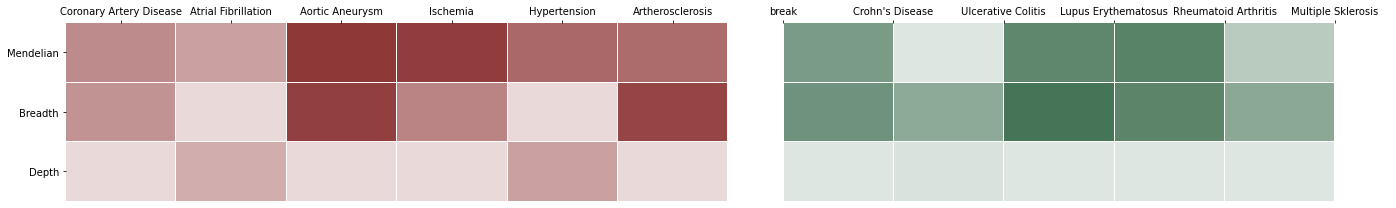

In [35]:
def plot_results(ors, pvals = None, need_transpose = True):
    """ ors and pvals are dicts which contain one df per disease. dfs have n_methods rows and n_disease_subtypes columns """
    import numpy as np
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    break_width = 0.5
    regular_width = 1 - border_size
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    outer_labels = list(ors.keys())
    diseases = []
    one_large_df = None
    dfs = []
    subtype_to_main_mapping = {}

    for i, (disease, df) in enumerate(ors.items()):
        if need_transpose:
            df = df.transpose()
        for subtype in df.columns:
            subtype_to_main_mapping.update({subtype: [i, disease]})
        diseases.extend(list(df.columns) + ["break"])
        methods = df.index.tolist()[::-1]
        dfs.append(df)
    

    one_large_df = pd.concat(dfs, axis=1)
        
    print(one_large_df)
    
    

    # remove last break
    diseases = diseases[:-1]
    
    fig, ax = plt.subplots(figsize=(1.5 + (1.5*len(diseases)), 1*len(methods)))
    
    diseases_without_breaks = [label for label in diseases[::-1] if label != "break"]

    values = one_large_df.values

    for i, index in enumerate(methods):
        for c, column in enumerate(diseases):
                
            
            height = break_height if index == "break" else regular_height
            width = break_width if column == "break" else regular_width

            #minmax_means = (df[:,k] - np.min(df[:,k])) / (np.max(df[:,k]) - np.min(df[:,k]))
                
            if "break" in [index, column]:
                color = "w"
            else:
                colors = color_gradients[subtype_to_main_mapping[column][0]]
                value_disease_index = diseases_without_breaks.index(column)
                minmax_means = (values[:, value_disease_index] - 1) / (np.max(values[:, value_disease_index]) - 1)
                color = colors[int(100 * (1 - minmax_means[methods.index(index)]))]

            bottom = np.sum([break_height if _method == "break" else regular_height for _method in methods[:i]])

            x_position = np.sum([break_width if _disease == "break" else regular_height for _disease in diseases[:c]])

            ax.bar(x_position, height=height - border_size, bottom=bottom,
                                color=color, width=width)
                
            """
                if method != "break":
                    if df.columns[j] == "mean_rank_filtered":
                        color = "w" if minmax_means[diseases_without_breaks.index(method)] < 0.5 else "black"
                        text = str(int(means[diseases_without_breaks.index(method),k]))
                    else:
                        color = "w" if minmax_means[diseases_without_breaks.index(method)] > 0.5 else "black"
                        text = "{:.2f}".format(means[diseases_without_breaks.index(method),k])
                            
                    ax.text(k, bottom + (0.5*height), text, ha='center',
                                        weight='bold', size=12, color=color)
            """


    yticks = []
    for index in range(len(methods)):
        yticks.append(np.sum([break_height if label == "break" else regular_height for label in methods[:index + 1]]) - 0.5)

    xticks = []
    for index in range(len(diseases)):
        xticks.append(np.sum([break_width if label == "break" else regular_width for label in diseases[:index + 1]]) - 0.5)

    #ax.set_title(" ".join([word.capitalize() if word not in abbreviations.keys() else abbreviations[word] for word in df.columns[j].split("_")]))
    ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    ax.set_yticklabels([label for label in methods if label != "break"])
        
    ax.set_xticks(np.asarray(xticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    ax.set_xticklabels(diseases)

    #for location, text in zip([1, 4, 7, 10, 13], ["Only Network", "Only Features", "No Omics", "Network\n+ Features", "Ours"]):
    #    ax.text(-1.5, location, text, rotation=90, ha='center', va="center")

    ax.xaxis.set_ticks_position('top')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in methods]) - border_size))
    ax.set_xlim((- width/2, len(diseases) - ((width/2) + border_size)))

    plt.tight_layout()

    return fig, ax

plot_results(disease_ors, disease_pvals)

In [2]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes")

from speos.utils.config import Config
from speos.preprocessing.mappers import *
from speos.datasets import DatasetBootstrapper

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
config = Config()
config.parse_yaml("/home/icb/florin.ratajczak/ppi-core-genes/configs/config_cardiovascular_tag.yaml")
#print(config)
config.input.save_dir = "./data/"
config.logging.dir =  "./logs/"

mappings = GWASMapper().get_mappings(
            config.input.tag, fields=config.input.field)


adjacencies = AdjacencyMapper(blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)


#print(adjacencies)

dataset = DatasetBootstrapper(
            mappings, adjacencies, holdout_size=config.input.holdout_size, name=config.name, config=config).get_dataset()

prepro = dataset.preprocessor

Processing...
Done!
cardiovascular_tag 2022-09-12 14:58:47,130 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
cardiovascular_tag 2022-09-12 14:58:47,130 [INFO] speos.preprocessing.preprocessor: Using 8 mappings with ground truth data/mendelian_gene_sets/Cardiovascular_Disease_genes.bed 
cardiovascular_tag 2022-09-12 14:59:09,898 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17320
Number of edges: 14882
Average in degree:   0.8592
Average out degree:   0.8592
cardiovascular_tag 2022-09-12 14:59:10,186 [INFO] speos.preprocessing.preprocessor: Number of positives in ground truth data/mendelian_gene_sets/Cardiovascular_Disease_genes.bed: 584


In [5]:
prepro.id2hgnc[14]

'AAGAB'

In [6]:
hgnc2id = {value: key for key, value in prepro.id2hgnc.items()}

853

In [30]:
prepro.G[hgnc2id["PCNA"]]

AdjacencyView({7469: {0: {}}, 8577: {0: {}}, 2404: {0: {}}, 5472: {0: {}}, 2064: {0: {}}, 4404: {0: {}}, 4654: {0: {}}})

In [61]:
prepro.G[hgnc2id["ACADM"]]

AdjacencyView({119: {0: {}}})

In [59]:
hgnc2id["HSPB1"]

6637

In [60]:
dataset.data.y[6637]

tensor(0., dtype=torch.float64)

In [31]:
dataset.data.y.shape

torch.Size([17320])

In [32]:
len(hgnc2id)

19220

In [33]:
len(prepro.G.nodes)

17320

In [39]:

hgnc2id = {prepro.G.nodes[i]["hgnc"]: i for i in range(len(prepro.G.nodes))}

In [43]:
import matplotlib.pyplot as plt

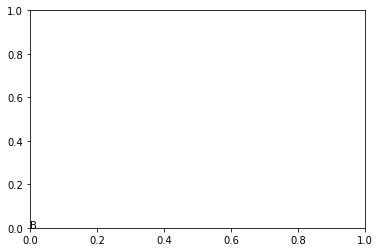

In [49]:
fig, ax = plt.subplots() 

ax.text(0,0, "a")

ax.texts[0]._text = "B"

text = "b"
#text = ax.get_text()